# Battle of the Neighborhoods
## Best location for a seafood restaurant in Paris, France
### *Julien DELMAS*
***

## Introduction

Paris is the administrative, economic and demographic capital of France. With over 2.2 million inhabitants, it is also the first touristic destination in the country and it is reknown for its cuisine.
There are hundreds of restaurants in Paris most of them being French restaurant (mainly "brasserie") or Italian restaurants.

For this capstone project, I decided to suppose that I want to open a seafood restaurant in Paris and the goal is to find the best place to locate such a restaurant.

**Note that this Jupyter notebook, only contains the documented code of the project. For the detailed analysis of the data and the results, please see the report and the presentation:**
- Report:
- Presentation:

## 1. Initialization

In this section we initialize some constants and we define some functions.

Private keys and tokens:

In [1]:
# @hidden_cell
PROJECT_ID = '4a04871d-c0d7-4bc8-9f63-08f04cabbb5e' #IBM Watson Studio project id
PROJECT_ACCESS_TOKEN = 'p-e179c49b6c911431e39c3fe5be1b86680ba2d2b2' #The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
FOURSQUARE_CLIENT_ID = '3PSVXRPXIS05WU23MXVPUDU15ODZACTIVMMD3RXIH1EBS3UJ' #Foursquare ID
FOURSQUARE_CLIENT_SECRET = '4BXND3VFVEHGIUX4QSPE00OW5ZB1Z1IMP1MLLDEBNM2T2XHT' #Foursquare Secret
FOURSQUARE_VERSION = '20180605' #Foursquare API version

Project constants:

In [2]:
#Foursquare
RESTAURANT_CATEGORY = 'seafood' #No space or special character
FOURSQUARE_CATEGORY = '4bf58dd8d48988d1ce941735' #Category for seafood restaurants, see https://developer.foursquare.com/docs/build-with-foursquare/categories/
FOURSQUARE_RADIUS = 1500 #Radius that should allow to cover every neighborhood
FOURSQUARE_LIMIT = 100 #Number of result per query
FOURSQUARE_UPDATE = False #Do we search the data in Foursquare or do we use the local data? This field is useful to avoid reaching the maximum queries per day

#Geography
PARIS_COORDINATES = [48.866667, 2.333333]

Code to access project resources like data sources, connections, and used by platform APIs.

In [3]:
from project_lib import Project
project = Project(project_id=PROJECT_ID, project_access_token=PROJECT_ACCESS_TOKEN)
pc = project.project_context

Define functions:

In [4]:
def get_foursquare_venues(latitude, longitude, category='', radius=500, limit=100):
    """ 
    Obtain the list of venues around a certain position. 
    
    Parameters: 
        latitude (float): Latitude of the position.
        longitude (float): Longitude of the position.
        category (str): A comma-separated list of categories (see https://developer.foursquare.com/docs/build-with-foursquare/categories) to limit results to. If an empty string is passed, no filtering is done on category. (default: '')
        radius (int): Limit results to venues within this many meters of the specified location. The maximum supported radius is currently 100,000 meters. (default: 500)
        limit (int): Number of results to return. (default: 100)
    
    Returns: 
        None if an error occurred, otherwise
        Dataframe: A dataframe with the list of venues in row and the following columns:
            id: A unique string identifier for this venue.
            Name: The best known name for this venue.
            Latitude: latitude of the venue.
            Longitude: longitude of the venue.
    """
    
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&intent=browse'.format(
            FOURSQUARE_CLIENT_ID, 
            FOURSQUARE_CLIENT_SECRET, 
            FOURSQUARE_VERSION, 
            latitude, 
            longitude,
            radius, 
            limit)
    
    if category != '':
        url = url + '&categoryId={}'.format(
            category)
    
    results = requests.get(url).json()
    code = results['meta']['code'] #200 if everything went well, error code otherwise
    
    #If an error occurred, return None
    if code != 200:
        print(str(code) + ': ' + results['meta']['errorDetail'])
        return None
    
    #Loop on the venues in the json to build the dataframe
    venues = []
    for venue in results['response']['venues']:
        try:
            id = venue['id']
            name = venue['name']
            latitude = venue['location']['lat']
            longitude = venue['location']['lng']
            venues.append([id, name, latitude, longitude])
        except KeyError:
            pass
    
    columns = ['id', 'Name', 'Latitude', 'Longitude']
    df = pd.DataFrame(venues,columns=columns)

    return df


def get_foursquare_venue_details(venue_id, category=None):
    """ 
    Obtain the details of a specific venue. 
    
    Parameters: 
        id (str): A unique string identifier for this venue.
        (optional) category (str): A Foursquare category (see https://developer.foursquare.com/docs/build-with-foursquare/categories) that will be used to populate the *IsPrimaryCategory* result.
    
    Returns:
        None if an error occurred, otherwise
        Dict: A dictionary with the details of the venue:
            id (str): A unique string identifier for this venue.
            Name (str): The best known name for this venue.
            Price (int): price range from 1 (least pricey) to 4 (most pricey).
            PriceDescription (str): description of the Price result.
            Rating (float): Numerical rating of the venue (0 through 10). Not all venues will have a rating.
            Likes (int): Number of likes of the venue.
            TipsCount (int): NUmber of tips of the venue.
            IsPrimaryCategory (bool): True if the category input in parameters is the primary category of the venue, False oterwise. If the category is not passed as parameter, NaN is returned.
    """
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            FOURSQUARE_CLIENT_ID, 
            FOURSQUARE_CLIENT_SECRET, 
            FOURSQUARE_VERSION)

    results = requests.get(url).json()
    code = results['meta']['code'] #200 if everything went well, error code otherwise
    
    #If an error occurred, return None
    if code != 200:
        print(str(code) + ': ' + results['meta']['errorDetail'])
        return None
    
    venue_data = results['response']['venue']
    
    #Add each field to the dictionnary. If it is not included in the result, return NaN
    try:
        name = venue_data['name']
    except KeyError:
        name = np.nan
    
    try:
        price = venue_data['price']['tier']
    except KeyError:
        price = np.nan
    
    try:
        price_description = venue_data['price']['message']
    except KeyError:
        price_description = np.nan
    
    try:
        rating = venue_data['rating']
    except KeyError:
        rating = np.nan
        
    try:
        likes = venue_data['likes']['count']
    except KeyError:
        likes = np.nan
    
    try:
        tips_count = venue_data['tips']['count']
    except KeyError:
        tips_count = np.nan
    
    try:
        if category is not None:
            is_primary_category = False
            for venue_category in venue_data['categories']:
                if venue_category['id'] == category and venue_category['primary'] is True:
                    is_primary_category = True
        else:
            is_primary_category = np.nan;
    except KeyError:
        is_primary_category = np.nan
        
    venue = {'id': venue_id, 'Name': name, 'Price': price, 'PriceDescription': price_description, 'Rating': rating, 'Likes': likes, 'TipsCount': tips_count, 'IsPrimaryCategory': is_primary_category}

    return venue

Get the documentation of the *get_foursquare_venues()* function.

In [5]:
print(get_foursquare_venues.__doc__)

 
    Obtain the list of venues around a certain position. 
    
    Parameters: 
        latitude (float): Latitude of the position.
        longitude (float): Longitude of the position.
        category (str): A comma-separated list of categories (see https://developer.foursquare.com/docs/build-with-foursquare/categories) to limit results to. If an empty string is passed, no filtering is done on category. (default: '')
        radius (int): Limit results to venues within this many meters of the specified location. The maximum supported radius is currently 100,000 meters. (default: 500)
        limit (int): Number of results to return. (default: 100)
    
    Returns: 
        None if an error occurred, otherwise
        Dataframe: A dataframe with the list of venues in row and the following columns:
            id: A unique string identifier for this venue.
            Name: The best known name for this venue.
            Latitude: latitude of the venue.
            Longitude: longit

Get the documentation of the *get_foursquare_venue_details()* function.

In [6]:
print(get_foursquare_venue_details.__doc__)

 
    Obtain the details of a specific venue. 
    
    Parameters: 
        id (str): A unique string identifier for this venue.
        (optional) category (str): A Foursquare category (see https://developer.foursquare.com/docs/build-with-foursquare/categories) that will be used to populate the *IsPrimaryCategory* result.
    
    Returns:
        None if an error occurred, otherwise
        Dict: A dictionary with the details of the venue:
            id (str): A unique string identifier for this venue.
            Name (str): The best known name for this venue.
            Price (int): price range from 1 (least pricey) to 4 (most pricey).
            PriceDescription (str): description of the Price result.
            Rating (float): Numerical rating of the venue (0 through 10). Not all venues will have a rating.
            Likes (int): Number of likes of the venue.
            TipsCount (int): NUmber of tips of the venue.
            IsPrimaryCategory (bool): True if the category

## 2. Get and visualize data from Paris

### Import libraries

In [7]:
import pandas as pd
print('pandas library imported.')
import numpy as np
print('numpy library imported.')
import requests
print('requests library imported.')
from bs4 import BeautifulSoup
print('BeautifulSoup library imported.')
import json
print('json imported.')

print('All libraries imported.')

pandas library imported.
numpy library imported.
requests library imported.
BeautifulSoup library imported.
json imported.
All libraries imported.


### Get data from Paris Opendata database

#### Download the data

Get a csv with data concerning the neighborhood of Paris from the Opendata site of City of Paris: https://opendata.paris.fr/explore/dataset/quartier_paris/information/.

In [8]:
!wget --quiet https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=csv -O paris_neighborhoods.csv
print('CSV file downloaded.')

CSV file downloaded.


Read the csv and store in a Pandas dataframe.

In [9]:
paris_neighborhoods = pd.read_csv('paris_neighborhoods.csv', sep=';')

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 10).
The dataframe types are:
n_sq_qu        int64
c_qu           int64
c_quinsee      int64
l_qu          object
c_ar           int64
n_sq_ar        int64
perimetre    float64
surface      float64
geom_x_y      object
geom          object
dtype: object.


n_sq_qu  c_qu  c_quinsee            l_qu  c_ar    n_sq_ar    perimetre  \
0  750000021    21    7510601         Monnaie     6  750000006  2391.122818   
1  750000022    22    7510602           Odéon     6  750000006  3516.314464   
2  750000029    29    7510801  Champs-Elysées     8  750000008  5480.652870   
3  750000051    51    7511303  Maison-Blanche    13  750000013  6814.373288   
4  750000052    52    7511304     Croulebarbe    13  750000013  3289.230480   

        surface                     geom_x_y  \
0  2.933606e+05  48.8543844036,2.34003537113   
1  7.161484e+05  48.8478006293,2.33633882759   
2  1.140254e+06  48.8670744922,2.30865168468   
3  2.231506e+06  48.8231278057,2.35243314954   
4  6.920677e+05  48.8337336761,2.34767304607   

                                                geom  
0  {"type": "Polygon", "coordinates": [[[2.343168...  
1  {"type": "Polygon", "coordinates": [[[2.336988...  
2  {"type": "Polygon", "coordinates": [[[2.306463...  
3  {"type": "Polygon", "coordinates": [[[2.349115...  
4  {"type": "Polygon", "coordinates": [[[2.351662...

Save the data downloaded into a CSV file.

In [10]:
project.save_data(file_name='paris_opendata.csv', data=paris_neighborhoods.to_csv(index=False, encoding='utf-8'), overwrite=True)

print('File paris_opendata.csv saved.')

File paris_opendata.csv saved.


#### Clean the dataframe from Paris Opendata

Drop the columns we will not use.

In [11]:
paris_neighborhoods.drop(['n_sq_qu', 'geom', 'n_sq_ar'], axis='columns', inplace=True)

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 7).
The dataframe types are:
c_qu           int64
c_quinsee      int64
l_qu          object
c_ar           int64
perimetre    float64
surface      float64
geom_x_y      object
dtype: object.


c_qu  c_quinsee            l_qu  c_ar    perimetre       surface  \
0    21    7510601         Monnaie     6  2391.122818  2.933606e+05   
1    22    7510602           Odéon     6  3516.314464  7.161484e+05   
2    29    7510801  Champs-Elysées     8  5480.652870  1.140254e+06   
3    51    7511303  Maison-Blanche    13  6814.373288  2.231506e+06   
4    52    7511304     Croulebarbe    13  3289.230480  6.920677e+05   

                      geom_x_y  
0  48.8543844036,2.34003537113  
1  48.8478006293,2.33633882759  
2  48.8670744922,2.30865168468  
3  48.8231278057,2.35243314954  
4  48.8337336761,2.34767304607

Rename the columns to easily understanable names.

In [12]:
paris_neighborhoods.columns = ['NeighborhoodNumber', 'NeighborhoodCode', 'Neighborhood', 'DistrictNumber', 'Perimeter', 'Area', 'Coordinates']

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 7).
The dataframe types are:
NeighborhoodNumber      int64
NeighborhoodCode        int64
Neighborhood           object
DistrictNumber          int64
Perimeter             float64
Area                  float64
Coordinates            object
dtype: object.


NeighborhoodNumber  NeighborhoodCode    Neighborhood  DistrictNumber  \
0                  21           7510601         Monnaie               6   
1                  22           7510602           Odéon               6   
2                  29           7510801  Champs-Elysées               8   
3                  51           7511303  Maison-Blanche              13   
4                  52           7511304     Croulebarbe              13   

     Perimeter          Area                  Coordinates  
0  2391.122818  2.933606e+05  48.8543844036,2.34003537113  
1  3516.314464  7.161484e+05  48.8478006293,2.33633882759  
2  5480.652870  1.140254e+06  48.8670744922,2.30865168468  
3  6814.373288  2.231506e+06  48.8231278057,2.35243314954  
4  3289.230480  6.920677e+05  48.8337336761,2.34767304607

Split the coordinates in 2 columns.

In [13]:
paris_neighborhoods[['Latitude', 'Longitude']] = paris_neighborhoods.Coordinates.str.split(",", expand=True)
paris_neighborhoods.drop(['Coordinates'], axis='columns', inplace=True)

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 8).
The dataframe types are:
NeighborhoodNumber      int64
NeighborhoodCode        int64
Neighborhood           object
DistrictNumber          int64
Perimeter             float64
Area                  float64
Latitude               object
Longitude              object
dtype: object.


NeighborhoodNumber  NeighborhoodCode    Neighborhood  DistrictNumber  \
0                  21           7510601         Monnaie               6   
1                  22           7510602           Odéon               6   
2                  29           7510801  Champs-Elysées               8   
3                  51           7511303  Maison-Blanche              13   
4                  52           7511304     Croulebarbe              13   

     Perimeter          Area       Latitude      Longitude  
0  2391.122818  2.933606e+05  48.8543844036  2.34003537113  
1  3516.314464  7.161484e+05  48.8478006293  2.33633882759  
2  5480.652870  1.140254e+06  48.8670744922  2.30865168468  
3  6814.373288  2.231506e+06  48.8231278057  2.35243314954  
4  3289.230480  6.920677e+05  48.8337336761  2.34767304607

Convert area from sqare meters to square kilometers.

In [14]:
paris_neighborhoods[['Area']] = paris_neighborhoods[['Area']]/1e6

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 8).
The dataframe types are:
NeighborhoodNumber      int64
NeighborhoodCode        int64
Neighborhood           object
DistrictNumber          int64
Perimeter             float64
Area                  float64
Latitude               object
Longitude              object
dtype: object.


NeighborhoodNumber  NeighborhoodCode    Neighborhood  DistrictNumber  \
0                  21           7510601         Monnaie               6   
1                  22           7510602           Odéon               6   
2                  29           7510801  Champs-Elysées               8   
3                  51           7511303  Maison-Blanche              13   
4                  52           7511304     Croulebarbe              13   

     Perimeter      Area       Latitude      Longitude  
0  2391.122818  0.293361  48.8543844036  2.34003537113  
1  3516.314464  0.716148  48.8478006293  2.33633882759  
2  5480.652870  1.140254  48.8670744922  2.30865168468  
3  6814.373288  2.231506  48.8231278057  2.35243314954  
4  3289.230480  0.692068  48.8337336761  2.34767304607

### Get additional data from Wikipedia

#### Download the data

Scrape the Wikipedia page about the neighborhoods of Paris: https://en.wikipedia.org/wiki/Quarters_of_Paris.

In [15]:
result = requests.get("https://en.wikipedia.org/wiki/Quarters_of_Paris")
soup = BeautifulSoup(result.content,'lxml')
table = soup.find_all('table')[0] 
paris_neighborhoods_wikipedia = pd.read_html(str(table))[0]

print('The dataframe shape is {}.'.format(paris_neighborhoods_wikipedia.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods_wikipedia.dtypes))
paris_neighborhoods_wikipedia.head()

The dataframe shape is (80, 6).
The dataframe types are:
Arrondissement(Districts)     object
Quartiers(Quarters)           object
Quartiers(Quarters).1         object
Population in1999[3]           int64
Area(hectares)[3]            float64
Map                          float64
dtype: object.


Arrondissement(Districts) Quartiers(Quarters)  \
0     1st arrondissement(Called "du Louvre")                 1st   
1     1st arrondissement(Called "du Louvre")                 2nd   
2     1st arrondissement(Called "du Louvre")                 3rd   
3     1st arrondissement(Called "du Louvre")                 4th   
4  2nd arrondissement(Called "de la Bourse")                 5th   

       Quartiers(Quarters).1  Population in1999[3]  Area(hectares)[3]  Map  
0  Saint-Germain-l'Auxerrois                  1672               86.9  NaN  
1                 Les Halles                  8984               41.2  NaN  
2               Palais-Royal                  3195               27.4  NaN  
3              Place-Vendôme                  3044               26.9  NaN  
4                    Gaillon                  1345               18.8  NaN

#### Clean the dataframe from Wikipedia

Drop the columns we will not use.

In [16]:
paris_neighborhoods_wikipedia.drop(['Quartiers(Quarters).1', 'Area(hectares)[3]', 'Map'], axis='columns', inplace=True)

print('The dataframe shape is {}.'.format(paris_neighborhoods_wikipedia.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods_wikipedia.dtypes))
paris_neighborhoods_wikipedia.head()

The dataframe shape is (80, 3).
The dataframe types are:
Arrondissement(Districts)    object
Quartiers(Quarters)          object
Population in1999[3]          int64
dtype: object.


Arrondissement(Districts) Quartiers(Quarters)  \
0     1st arrondissement(Called "du Louvre")                 1st   
1     1st arrondissement(Called "du Louvre")                 2nd   
2     1st arrondissement(Called "du Louvre")                 3rd   
3     1st arrondissement(Called "du Louvre")                 4th   
4  2nd arrondissement(Called "de la Bourse")                 5th   

   Population in1999[3]  
0                  1672  
1                  8984  
2                  3195  
3                  3044  
4                  1345

Rename the columns.

In [17]:
paris_neighborhoods_wikipedia.columns = ['District', 'NeighborhoodNumber', 'Population']

print('The dataframe shape is {}.'.format(paris_neighborhoods_wikipedia.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods_wikipedia.dtypes))
paris_neighborhoods_wikipedia.head()

The dataframe shape is (80, 3).
The dataframe types are:
District              object
NeighborhoodNumber    object
Population             int64
dtype: object.


District NeighborhoodNumber  Population
0     1st arrondissement(Called "du Louvre")                1st        1672
1     1st arrondissement(Called "du Louvre")                2nd        8984
2     1st arrondissement(Called "du Louvre")                3rd        3195
3     1st arrondissement(Called "du Louvre")                4th        3044
4  2nd arrondissement(Called "de la Bourse")                5th        1345

Split the district official name (number of the "arrondissement") and the "also called" named (which is not commonly used in Paris but we keep it in case we need it afterwards).

In [18]:
paris_neighborhoods_wikipedia[['District', 'DistrictName']] = paris_neighborhoods_wikipedia.District.str.split("(",expand=True,)

print('The dataframe shape is {}.'.format(paris_neighborhoods_wikipedia.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods_wikipedia.dtypes))
paris_neighborhoods_wikipedia.head()

The dataframe shape is (80, 4).
The dataframe types are:
District              object
NeighborhoodNumber    object
Population             int64
DistrictName          object
dtype: object.


District NeighborhoodNumber  Population            DistrictName
0  1st arrondissement                1st        1672     Called "du Louvre")
1  1st arrondissement                2nd        8984     Called "du Louvre")
2  1st arrondissement                3rd        3195     Called "du Louvre")
3  1st arrondissement                4th        3044     Called "du Louvre")
4  2nd arrondissement                5th        1345  Called "de la Bourse")

Make the district name more beautiful.

In [19]:
paris_neighborhoods_wikipedia[['DistrictName']] = paris_neighborhoods_wikipedia.DistrictName.str.replace('Called \"', 'Arrondissement ')
paris_neighborhoods_wikipedia[['DistrictName']] = paris_neighborhoods_wikipedia.DistrictName.str.replace("\"\)", '')

print('The dataframe shape is {}.'.format(paris_neighborhoods_wikipedia.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods_wikipedia.dtypes))
paris_neighborhoods_wikipedia.head()

The dataframe shape is (80, 4).
The dataframe types are:
District              object
NeighborhoodNumber    object
Population             int64
DistrictName          object
dtype: object.


District NeighborhoodNumber  Population  \
0  1st arrondissement                1st        1672   
1  1st arrondissement                2nd        8984   
2  1st arrondissement                3rd        3195   
3  1st arrondissement                4th        3044   
4  2nd arrondissement                5th        1345   

                  DistrictName  
0     Arrondissement du Louvre  
1     Arrondissement du Louvre  
2     Arrondissement du Louvre  
3     Arrondissement du Louvre  
4  Arrondissement de la Bourse

Remove the cardinality (the letters) from the neighborhood number and cast the result to integer.

In [20]:
paris_neighborhoods_wikipedia[['NeighborhoodNumber']] = paris_neighborhoods_wikipedia.NeighborhoodNumber.str[:-2]
paris_neighborhoods_wikipedia = paris_neighborhoods_wikipedia.astype({'NeighborhoodNumber': int})

print('The dataframe shape is {}.'.format(paris_neighborhoods_wikipedia.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods_wikipedia.dtypes))
paris_neighborhoods_wikipedia.head()

The dataframe shape is (80, 4).
The dataframe types are:
District              object
NeighborhoodNumber     int64
Population             int64
DistrictName          object
dtype: object.


District  NeighborhoodNumber  Population  \
0  1st arrondissement                   1        1672   
1  1st arrondissement                   2        8984   
2  1st arrondissement                   3        3195   
3  1st arrondissement                   4        3044   
4  2nd arrondissement                   5        1345   

                  DistrictName  
0     Arrondissement du Louvre  
1     Arrondissement du Louvre  
2     Arrondissement du Louvre  
3     Arrondissement du Louvre  
4  Arrondissement de la Bourse

### Merge of the data of Paris Opendata and Wikipedia

#### Merge the two dataframes

In [21]:
paris_neighborhoods = pd.merge(paris_neighborhoods, paris_neighborhoods_wikipedia, on='NeighborhoodNumber')

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 11).
The dataframe types are:
NeighborhoodNumber      int64
NeighborhoodCode        int64
Neighborhood           object
DistrictNumber          int64
Perimeter             float64
Area                  float64
Latitude               object
Longitude              object
District               object
Population              int64
DistrictName           object
dtype: object.


NeighborhoodNumber  NeighborhoodCode    Neighborhood  DistrictNumber  \
0                  21           7510601         Monnaie               6   
1                  22           7510602           Odéon               6   
2                  29           7510801  Champs-Elysées               8   
3                  51           7511303  Maison-Blanche              13   
4                  52           7511304     Croulebarbe              13   

     Perimeter      Area       Latitude      Longitude             District  \
0  2391.122818  0.293361  48.8543844036  2.34003537113   6th arrondissement   
1  3516.314464  0.716148  48.8478006293  2.33633882759   6th arrondissement   
2  5480.652870  1.140254  48.8670744922  2.30865168468   8th arrondissement   
3  6814.373288  2.231506  48.8231278057  2.35243314954  13th arrondissement   
4  3289.230480  0.692068  48.8337336761  2.34767304607  13th arrondissement   

   Population                  DistrictName  
0        6185  Arrondissement du Luxembourg  
1        8833  Arrondissement du Luxembourg  
2        4614    Arrondissement de l'Élysée  
3       64797   Arrondissement des Gobelins  
4       19526   Arrondissement des Gobelins

#### Add additional data

Add the postal code which is 75 (number of department in France) + 0 + number of the district. It gives a number between 75001 and 75020

In [22]:
paris_neighborhoods['PostalCode'] = '750' + paris_neighborhoods.District.str.split(' ').str[0].str[:-2].str.rjust(2, '0')

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 12).
The dataframe types are:
NeighborhoodNumber      int64
NeighborhoodCode        int64
Neighborhood           object
DistrictNumber          int64
Perimeter             float64
Area                  float64
Latitude               object
Longitude              object
District               object
Population              int64
DistrictName           object
PostalCode             object
dtype: object.


NeighborhoodNumber  NeighborhoodCode    Neighborhood  DistrictNumber  \
0                  21           7510601         Monnaie               6   
1                  22           7510602           Odéon               6   
2                  29           7510801  Champs-Elysées               8   
3                  51           7511303  Maison-Blanche              13   
4                  52           7511304     Croulebarbe              13   

     Perimeter      Area       Latitude      Longitude             District  \
0  2391.122818  0.293361  48.8543844036  2.34003537113   6th arrondissement   
1  3516.314464  0.716148  48.8478006293  2.33633882759   6th arrondissement   
2  5480.652870  1.140254  48.8670744922  2.30865168468   8th arrondissement   
3  6814.373288  2.231506  48.8231278057  2.35243314954  13th arrondissement   
4  3289.230480  0.692068  48.8337336761  2.34767304607  13th arrondissement   

   Population                  DistrictName PostalCode  
0        6185  Arrondissement du Luxembourg      75006  
1        8833  Arrondissement du Luxembourg      75006  
2        4614    Arrondissement de l'Élysée      75008  
3       64797   Arrondissement des Gobelins      75013  
4       19526   Arrondissement des Gobelins      75013

#### Clean the dataframe

Reorganize columns.

In [23]:
paris_neighborhoods = paris_neighborhoods[['NeighborhoodCode', 'NeighborhoodNumber', 'Neighborhood', 'DistrictNumber', 'District', 'DistrictName', 'PostalCode', 'Population', 'Area', 'Perimeter', 'Latitude', 'Longitude']]

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 12).
The dataframe types are:
NeighborhoodCode        int64
NeighborhoodNumber      int64
Neighborhood           object
DistrictNumber          int64
District               object
DistrictName           object
PostalCode             object
Population              int64
Area                  float64
Perimeter             float64
Latitude               object
Longitude              object
dtype: object.


NeighborhoodCode  NeighborhoodNumber    Neighborhood  DistrictNumber  \
0           7510601                  21         Monnaie               6   
1           7510602                  22           Odéon               6   
2           7510801                  29  Champs-Elysées               8   
3           7511303                  51  Maison-Blanche              13   
4           7511304                  52     Croulebarbe              13   

              District                  DistrictName PostalCode  Population  \
0   6th arrondissement  Arrondissement du Luxembourg      75006        6185   
1   6th arrondissement  Arrondissement du Luxembourg      75006        8833   
2   8th arrondissement    Arrondissement de l'Élysée      75008        4614   
3  13th arrondissement   Arrondissement des Gobelins      75013       64797   
4  13th arrondissement   Arrondissement des Gobelins      75013       19526   

       Area    Perimeter       Latitude      Longitude  
0  0.293361  2391.122818  48.8543844036  2.34003537113  
1  0.716148  3516.314464  48.8478006293  2.33633882759  
2  1.140254  5480.652870  48.8670744922  2.30865168468  
3  2.231506  6814.373288  48.8231278057  2.35243314954  
4  0.692068  3289.230480  48.8337336761  2.34767304607

Cast PostalCode and NeighborhoodCode columns to integer.

In [24]:
paris_neighborhoods = paris_neighborhoods.astype({'PostalCode': int, 'Latitude': float, 'Longitude': float})

print('The dataframe shape is {}.'.format(paris_neighborhoods.shape))
print('The dataframe types are:\n{}.'.format(paris_neighborhoods.dtypes))
paris_neighborhoods.head()

The dataframe shape is (80, 12).
The dataframe types are:
NeighborhoodCode        int64
NeighborhoodNumber      int64
Neighborhood           object
DistrictNumber          int64
District               object
DistrictName           object
PostalCode              int64
Population              int64
Area                  float64
Perimeter             float64
Latitude              float64
Longitude             float64
dtype: object.


NeighborhoodCode  NeighborhoodNumber    Neighborhood  DistrictNumber  \
0           7510601                  21         Monnaie               6   
1           7510602                  22           Odéon               6   
2           7510801                  29  Champs-Elysées               8   
3           7511303                  51  Maison-Blanche              13   
4           7511304                  52     Croulebarbe              13   

              District                  DistrictName  PostalCode  Population  \
0   6th arrondissement  Arrondissement du Luxembourg       75006        6185   
1   6th arrondissement  Arrondissement du Luxembourg       75006        8833   
2   8th arrondissement    Arrondissement de l'Élysée       75008        4614   
3  13th arrondissement   Arrondissement des Gobelins       75013       64797   
4  13th arrondissement   Arrondissement des Gobelins       75013       19526   

       Area    Perimeter   Latitude  Longitude  
0  0.293361  2391.122818  48.854384   2.340035  
1  0.716148  3516.314464  48.847801   2.336339  
2  1.140254  5480.652870  48.867074   2.308652  
3  2.231506  6814.373288  48.823128   2.352433  
4  0.692068  3289.230480  48.833734   2.347673

Save data to IBM Cloud.

In [25]:
project.save_data(file_name='paris_neighborhoods.csv', data=paris_neighborhoods.to_csv(index=False, encoding='utf-8'), overwrite=True)

print('File paris_neighborhoods.csv saved.')

File paris_neighborhoods.csv saved.


### Visualisation of the neighborhoods

#### Import libraries

In [26]:
try:
    import folium
except:
    print('folium not installed, installing folium.')
    !conda install -c conda-forge folium
    print('folium installed.')
    import folium
print('folium imported.')
import matplotlib.pyplot as plt
print('matplotlib.pyplot library imported.')
import matplotlib.image as mpimg
print('matplotlib.image library imported.')

print('All libraries imported.')

folium imported.
matplotlib.pyplot library imported.
matplotlib.image library imported.
All libraries imported.


#### Draw a choropleth map of the neighborhoods and their population

Get a GeoJSON file with the neighborhood of Paris from the Opendata site of the City of Paris.

In [27]:
!wget --quiet https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=geojson -O paris_neighborhoods_geo.json

print('GeoJSON file downloaded.')

with open('paris_neighborhoods_geo.json') as geojson:
    paris_neighborhoods_geo = json.load(geojson)

GeoJSON file downloaded.


Save the GeoJSON to IBM Cloud.

In [28]:
project.save_data(file_name='paris_neighborhoods_geo.json', data=json.dumps(paris_neighborhoods_geo), overwrite=True)
print('File paris_neighborhoods_geo.json saved.')

File paris_neighborhoods_geo.json saved.


Load the GeoJSON to a variable.

In [29]:
paris_neighborhoods_geo = r'paris_neighborhoods_geo.json'

Display the chloropeth map:  
- Map of Paris with OpenStreetMap
- Add the neighborhoods boundary thanks to the GeoJSON,
- Add a choropleth based on the population per neighborhood,
- Add a tooltip with the name of the neighborhood.

In [30]:
paris_map_population = folium.Map(location=PARIS_COORDINATES, zoom_start=13, tiles='OpenStreetMap')

choropleth = folium.Choropleth(
    geo_data=paris_neighborhoods_geo,
    data=paris_neighborhoods,
    columns=['NeighborhoodCode', 'Population'],
    key_on='feature.properties.c_quinsee',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Neighborhoods of Paris by population in 1999'
).add_to(paris_map_population)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['l_qu'],labels=False)
).add_to(paris_map_population)

paris_map_population

#### Draw a Scatter plot of the population vs the area of neighborhoods

Create a new dataframe with only the needed columns for the scatter plot.

In [31]:
scatter_plot_df = paris_neighborhoods[['Neighborhood', 'Population', 'Area']].copy()

print('The dataframe shape is {}.'.format(scatter_plot_df.shape))
print('The dataframe types are:\n{}.'.format(scatter_plot_df.dtypes))
scatter_plot_df.head()

The dataframe shape is (80, 3).
The dataframe types are:
Neighborhood     object
Population        int64
Area            float64
dtype: object.


Neighborhood  Population      Area
0         Monnaie        6185  0.293361
1           Odéon        8833  0.716148
2  Champs-Elysées        4614  1.140254
3  Maison-Blanche       64797  2.231506
4     Croulebarbe       19526  0.692068

Draw the scatter plot.

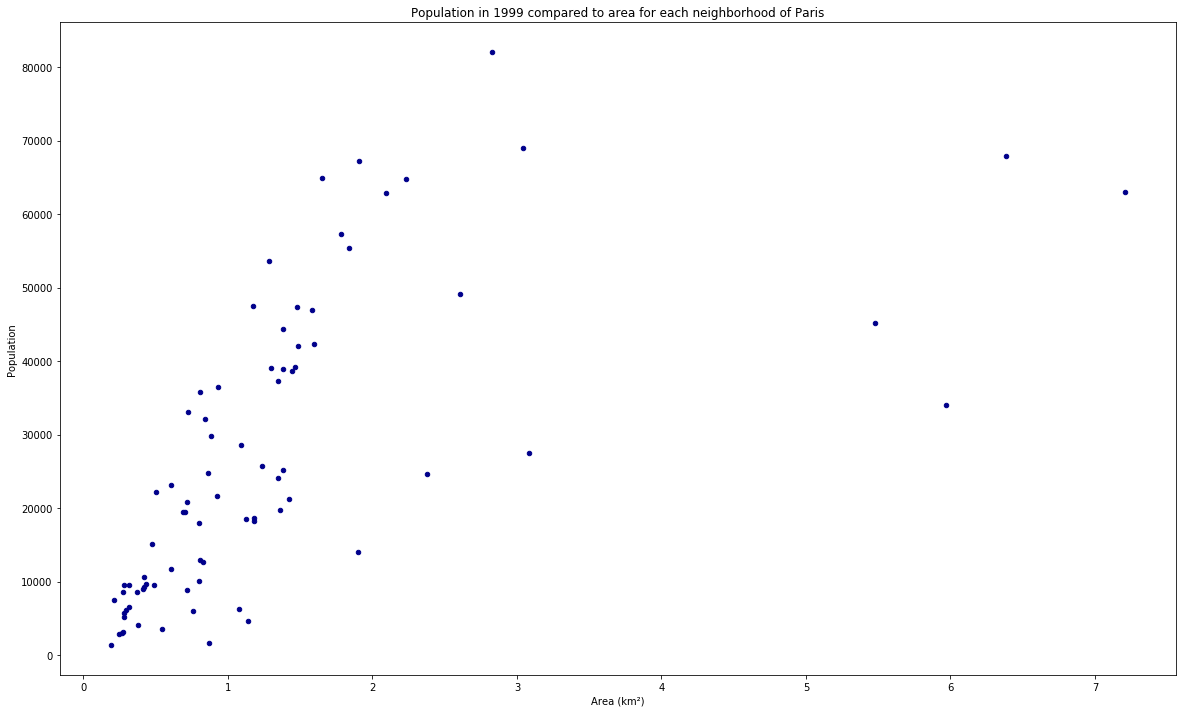

In [32]:
scatter_plot_df.plot(kind='scatter', x='Area', y='Population', figsize=(20, 12), color='darkblue')

plt.title('Population in 1999 compared to area for each neighborhood of Paris')
plt.xlabel('Area (km²)')
plt.ylabel('Population')

plt.show()

#### Draw a bar chart of the density of each neighborhood and each district

##### Draw a bar chart of the density of each neighborhood

Create a new dataframe with only the needed columns for the bar chart.

In [33]:
bar_chart_df = paris_neighborhoods[['Neighborhood', 'NeighborhoodCode', 'District', 'Population', 'Area']].copy()
bar_chart_df.set_index(['District', 'Neighborhood'], inplace=True)

Add a column with the density of each neighborhood.

In [34]:
bar_chart_df['Density'] = bar_chart_df['Population'] / bar_chart_df['Area']

print('The dataframe shape is {}.'.format(bar_chart_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_df.dtypes))
bar_chart_df.head()

The dataframe shape is (80, 4).
The dataframe types are:
NeighborhoodCode      int64
Population            int64
Area                float64
Density             float64
dtype: object.


NeighborhoodCode  Population      Area  \
District            Neighborhood                                             
6th arrondissement  Monnaie                  7510601        6185  0.293361   
                    Odéon                    7510602        8833  0.716148   
8th arrondissement  Champs-Elysées           7510801        4614  1.140254   
13th arrondissement Maison-Blanche           7511303       64797  2.231506   
                    Croulebarbe              7511304       19526  0.692068   

                                         Density  
District            Neighborhood                  
6th arrondissement  Monnaie         21083.269477  
                    Odéon           12334.036638  
8th arrondissement  Champs-Elysées   4046.466869  
13th arrondissement Maison-Blanche  29037.343810  
                    Croulebarbe     28214.002311

Sort the dataframe by density in order to obtain a nicer bar chart.

In [35]:
bar_chart_neighborhood_df = bar_chart_df[['Density']].sort_values(by=['Density'], ascending=True)

print('The dataframe shape is {}.'.format(bar_chart_neighborhood_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_neighborhood_df.dtypes))
bar_chart_neighborhood_df.head()

The dataframe shape is (80, 1).
The dataframe types are:
Density    float64
dtype: object.


Density
District            Neighborhood                          
1st arrondissement  Saint-Germain-l'Auxerrois  1924.049162
8th arrondissement  Champs-Elysées             4046.466869
12th arrondissement Bel-Air                    5690.244910
7th arrondissement  Invalides                  5845.024327
9th arrondissement  Chaussée-d'Antin           6418.358062

Draw the bar chart.

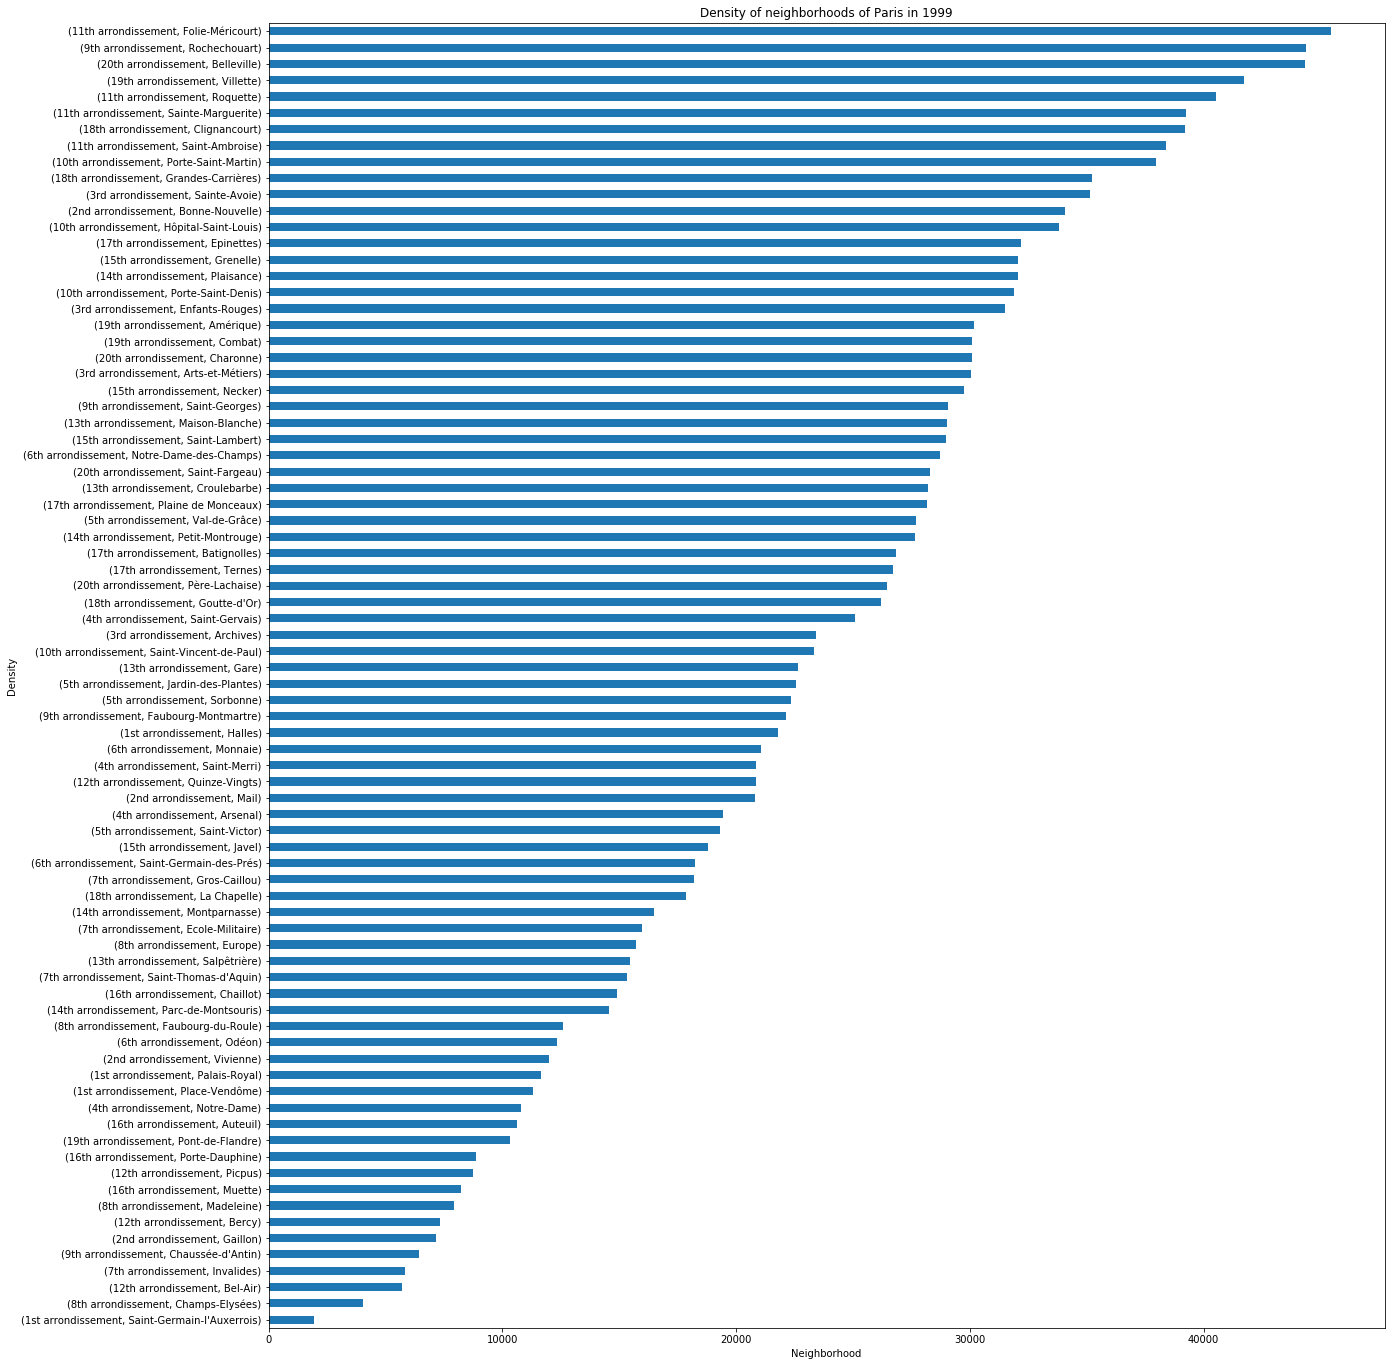

In [36]:
bar_chart_neighborhood_df.plot(kind='barh', figsize=(20, 24))

plt.xlabel('Neighborhood')
plt.ylabel('Density')
plt.title('Density of neighborhoods of Paris in 1999')
plt.legend().remove()

plt.show()

##### Draw a choropleth map of the density of each neighborhood

Load the GeoJSON.

In [37]:
paris_neighborhoods_geo_file = project.get_file('paris_neighborhoods_geo.json')
paris_neighborhoods_geo = pd.read_json(paris_neighborhoods_geo_file)
print('File paris_neighborhoods_geo.json loaded.')

paris_neighborhoods_geo = r'paris_neighborhoods_geo.json'

File paris_neighborhoods_geo.json loaded.


Display the chloropeth map:  
- Map of Paris with OpenStreetMap
- Add the neighborhoods boundary thanks to the GeoJSON,
- Add a choropleth based on the density per neighborhood,
- Add a tooltip with the name of the neighborhood.

In [38]:
paris_map_density = folium.Map(location=PARIS_COORDINATES, zoom_start=13, tiles='OpenStreetMap')

choropleth = folium.Choropleth(
    geo_data=paris_neighborhoods_geo,
    data=bar_chart_df,
    columns=['NeighborhoodCode', 'Density'],
    key_on='feature.properties.c_quinsee',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Neighborhoods of Paris by density in 1999'
).add_to(paris_map_density)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['l_qu'],labels=False)
).add_to(paris_map_density)

paris_map_density

##### Draw a bar chart of the density of each district

Create a new dataframe grouped by district.

In [39]:
bar_chart_district_df = bar_chart_df.groupby('District').sum()

Recalculate density by district

In [40]:
bar_chart_district_df['Density'] = bar_chart_district_df['Population'] / bar_chart_district_df['Area']

Sort the dataframe by density in order to obtain a nicer bar chart.

In [41]:
bar_chart_district_df = bar_chart_district_df[['Density']].sort_values(by=['Density'], ascending=True)

print('The dataframe shape is {}.'.format(bar_chart_district_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_district_df.dtypes))
bar_chart_district_df.head()

The dataframe shape is (20, 1).
The dataframe types are:
Density    float64
dtype: object.


Density
District                         
12th arrondissement   8376.574893
1st arrondissement    9259.499113
16th arrondissement   9883.439126
8th arrondissement   10129.543710
7th arrondissement   13933.301305

Draw the bar chart.

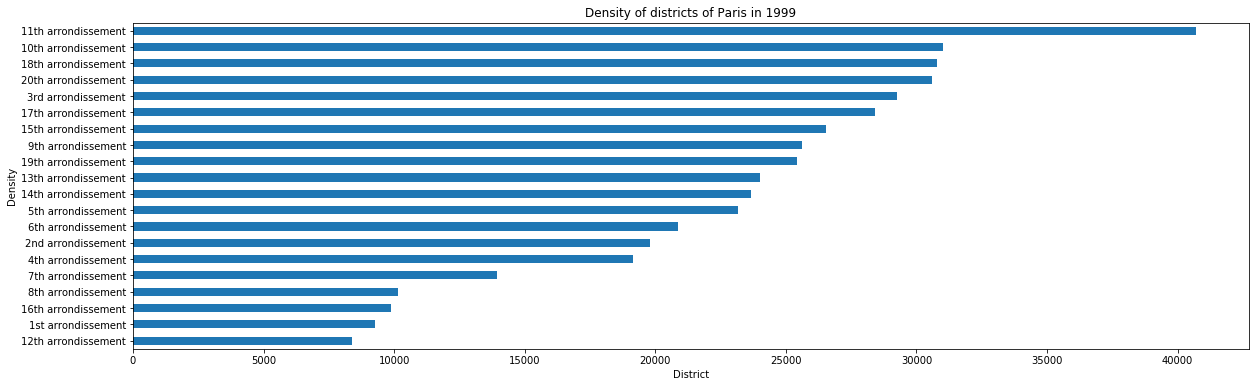

In [42]:
bar_chart_district_df.plot(kind='barh', figsize=(20, 6))

plt.xlabel('District')
plt.ylabel('Density')
plt.title('Density of districts of Paris in 1999')
plt.legend().remove()

plt.show()

## 3. Get and visualize the list of restaurants

### Get the data from Foursquare

#### Import the data

Get the list of restaurants in Paris for the category specified in the constants at the beginning of the file.

In [43]:
restaurants_foursquare = None
foursquare_error = False

if FOURSQUARE_UPDATE:
    #If we decided to update data from Foursquare (to parameterized in the constants at the beginning of the file)
    #For each neighborhood
    for id, neighborhood in paris_neighborhoods.iterrows():
        restaurants_neighborhood = get_foursquare_venues(neighborhood['Latitude'], neighborhood['Longitude'], FOURSQUARE_CATEGORY, FOURSQUARE_RADIUS, FOURSQUARE_LIMIT) #obtain the list of restaurants from Foursquare
        if restaurants_neighborhood is None:
            #If Foursquare returned an error (website down, quota reached...), change the foursquare_error variable and stop the loop
            foursquare_error = True
            break
        restaurants_foursquare = pd.concat([restaurants_foursquare, restaurants_neighborhood], ignore_index=True, sort=False) #add the list of restaurants for this neighborhood to the list of all Paris restaurants
    
    if foursquare_error:
        #If Foursquare returned an error (website down, quota reached...), we obtain the data from IBM Cloud  (data obtained previously from Foursquare, may not be up to date).
        restaurants_foursquare_file = project.get_file('restaurants_foursquare.csv')
        restaurants_foursquare = pd.read_csv(restaurants_foursquare_file, encoding='utf-8')
        print('File restaurants_foursquare.csv loaded.')
    else:
        #If there was no error, drop duplicates (we can get duplicates because restaurants close to the boundaries of a neighborhood can be obtained from multiple neighborhoods)
        restaurants_foursquare.drop_duplicates(subset='id', keep='first', inplace=True)
        #Save data to IBM Cloud
        project.save_data(file_name='restaurants_foursquare.csv', data=restaurants_foursquare.to_csv(index=False, encoding='utf-8'), overwrite=True)
        print('File restaurants_foursquare.csv saved.')
else:
    #If we decided to get the data from IBM Cloud (data obtained previously from Foursquare, may not be up to date but avoid to reach the maximum of Foursquare queries).
    restaurants_foursquare_file = project.get_file('restaurants_foursquare.csv')
    restaurants_foursquare = pd.read_csv(restaurants_foursquare_file, encoding='utf-8')
    print('File restaurants_foursquare.csv loaded.')

print('The dataframe shape is {}.'.format(restaurants_foursquare.shape))
print('The dataframe types are:\n{}.'.format(restaurants_foursquare.dtypes))
restaurants_foursquare.head()

File restaurants_foursquare.csv loaded.
The dataframe shape is (189, 4).
The dataframe types are:
id            object
Name          object
Latitude     float64
Longitude    float64
dtype: object.


id               Name   Latitude  Longitude
0  539a1714498e914689267233           La Criée  48.847991   2.348145
1  52f410b7498e6ecf60c0d4a7         Bar à Iode  48.849600   2.351608
2  5a7b5fc3898bdc101cd4486b      Homer Lobster  48.860706   2.354744
3  5954163f3ba76773801a02ba             Ostrea  48.861206   2.342601
4  4ea456aa61af76b39d5803a1  La Belle de Liron  48.866846   2.347244

Description of the dataframe obtained.

In [44]:
restaurants_foursquare.describe()

Latitude   Longitude
count  189.000000  189.000000
mean    48.861465    2.330261
std      0.016912    0.031417
min     48.815160    2.239556
25%     48.850952    2.313317
50%     48.862078    2.333255
75%     48.874305    2.351608
max     48.902006    2.407587

#### Add the neighborhood to each restaurant

Import libraries.

In [45]:
try:
    from shapely.geometry import Point, shape
except:
    print('shapely not installed, installing shapely.')
    !conda install -c conda-forge shapely
    print('shapely installed.')
    from shapely.geometry import Point, shape
print('shapely.geometry imported.')

print('All libraries imported.')

shapely.geometry imported.
All libraries imported.


Create a new dataframe.

In [46]:
restaurants_paris = pd.DataFrame(columns=['id', 'Name', 'Latitude', 'Longitude', 'NeighborhoodCode'])

For each restaurant, check in which neighborhood it is located by comparing the position (latitude, longitude) with the neighborhoods coordinates (based on the polygons of the GeoJSON obtained from Paris Opendata).

In [47]:
paris_neighborhoods_geo_file = project.get_file('paris_neighborhoods_geo.json')
paris_neighborhoods_geo = pd.read_json(paris_neighborhoods_geo_file)
print('File paris_neighborhoods_geo.json loaded.')

for id, restaurant in restaurants_foursquare.iterrows():
    #For each restaurant
    restaurant_location = Point(restaurant['Longitude'], restaurant['Latitude']) #Create a Point instance with the coordinates of the restaurant

    for feature in paris_neighborhoods_geo['features']:
        #For each neighborhood
        neighborhood = shape(feature['geometry']) #Create a Polygon instance with the coordinates of the neighborhood
        if restaurant_location.within(neighborhood):
            #If the restaurant is in the neighborhood, we add it to the new dataframe. If the restaurant is not in one of the neighborhoods (restaurant is in another city close to Paris), it is not added to the final dataframe
            restaurants_paris = restaurants_paris.append({'id': restaurant['id'], 'Name': restaurant['Name'], 'Latitude': restaurant['Latitude'], 'Longitude': restaurant['Longitude'], 'NeighborhoodCode': feature['properties']['c_quinsee']}, ignore_index=True, sort=False)
            break

print('The dataframe shape is {}.'.format(restaurants_paris.shape))
print('The dataframe types are:\n{}.'.format(restaurants_paris.dtypes))
restaurants_paris.head()

File paris_neighborhoods_geo.json loaded.
The dataframe shape is (180, 5).
The dataframe types are:
id                   object
Name                 object
Latitude            float64
Longitude           float64
NeighborhoodCode     object
dtype: object.


id               Name   Latitude  Longitude  \
0  539a1714498e914689267233           La Criée  48.847991   2.348145   
1  52f410b7498e6ecf60c0d4a7         Bar à Iode  48.849600   2.351608   
2  5a7b5fc3898bdc101cd4486b      Homer Lobster  48.860706   2.354744   
3  5954163f3ba76773801a02ba             Ostrea  48.861206   2.342601   
4  4ea456aa61af76b39d5803a1  La Belle de Liron  48.866846   2.347244   

  NeighborhoodCode  
0          7510504  
1          7510501  
2          7510401  
3          7510102  
4          7510203

Save the dataframe to IBM Cloud.

In [48]:
project.save_data(file_name=RESTAURANT_CATEGORY+'_restaurants_paris.csv', data=restaurants_paris.to_csv(index=False, encoding='utf-8'), overwrite=True)
print('File ' + RESTAURANT_CATEGORY + '_restaurants_paris.csv saved.')

File seafood_restaurants_paris.csv saved.


### Visualize the list of restaurants

#### Add the restaurants to a map

Add the restaurants to the choropleth map created above.

In [49]:
restaurants_map = folium.map.FeatureGroup()

for latitude, longitude, name in restaurants_paris[['Latitude', 'Longitude', 'Name']].values:
    restaurants_map.add_child(
        folium.CircleMarker(
            [latitude, longitude],
            radius=5,
            color='darkblue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            popup=name
        )
    )
    
paris_map_population.add_child(restaurants_map)

paris_map_population

#### Create a bar chart of the number of restaurants per neighborhood and per district

##### Bar chart of the number of restaurants per neighborhood

Create a new data frame with the list of restaurants and the details of each neighborhood

In [50]:
bar_chart_df = pd.merge(paris_neighborhoods[['NeighborhoodCode', 'Neighborhood', 'District',]], restaurants_paris[['NeighborhoodCode', 'id']], on='NeighborhoodCode', how='outer')

print('The dataframe shape is {}.'.format(bar_chart_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_df.dtypes))
bar_chart_df.head()

The dataframe shape is (196, 4).
The dataframe types are:
NeighborhoodCode    object
Neighborhood        object
District            object
id                  object
dtype: object.


NeighborhoodCode Neighborhood            District                        id
0          7510601      Monnaie  6th arrondissement  577aa48c38fad73635678a7f
1          7510601      Monnaie  6th arrondissement  56b5ba26498e6f4bddd43f39
2          7510601      Monnaie  6th arrondissement  4adcda14f964a5203e3721e3
3          7510601      Monnaie  6th arrondissement  4e18b750fa761946459459d2
4          7510601      Monnaie  6th arrondissement  5d2ac7e7605f260023aa8218

Drop columns we will not use and change index to Distrct and Neighborhood

In [51]:
bar_chart_df.drop(['NeighborhoodCode'], axis='columns', inplace=True)
bar_chart_df.set_index(['District', 'Neighborhood'], inplace=True)

print('The dataframe shape is {}.'.format(bar_chart_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_df.dtypes))
bar_chart_df.head()

The dataframe shape is (196, 1).
The dataframe types are:
id    object
dtype: object.


id
District           Neighborhood                          
6th arrondissement Monnaie       577aa48c38fad73635678a7f
                   Monnaie       56b5ba26498e6f4bddd43f39
                   Monnaie       4adcda14f964a5203e3721e3
                   Monnaie       4e18b750fa761946459459d2
                   Monnaie       5d2ac7e7605f260023aa8218

Count the number of restaurants per neighborhood and rename the result.

In [52]:
bar_chart_neighborhood_df = bar_chart_df.groupby(['District', 'Neighborhood']).count()
bar_chart_neighborhood_df.rename(columns={'id': 'RestaurantsCount'}, inplace=True)

print('The dataframe shape is {}.'.format(bar_chart_neighborhood_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_neighborhood_df.dtypes))
bar_chart_neighborhood_df.head()

The dataframe shape is (80, 1).
The dataframe types are:
RestaurantsCount    int64
dtype: object.


RestaurantsCount
District            Neighborhood                           
10th arrondissement Hôpital-Saint-Louis                   0
                    Porte-Saint-Denis                     4
                    Porte-Saint-Martin                    6
                    Saint-Vincent-de-Paul                 2
11th arrondissement Folie-Méricourt                       3

Sort by number of restaurants for a nicer bar chart.

In [53]:
bar_chart_neighborhood_df = bar_chart_neighborhood_df.sort_values(by=['RestaurantsCount'], ascending=True)

print('The dataframe shape is {}.'.format(bar_chart_neighborhood_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_neighborhood_df.dtypes))
bar_chart_neighborhood_df.head()

The dataframe shape is (80, 1).
The dataframe types are:
RestaurantsCount    int64
dtype: object.


RestaurantsCount
District            Neighborhood                               
10th arrondissement Hôpital-Saint-Louis                       0
1st arrondissement  Saint-Germain-l'Auxerrois                 0
2nd arrondissement  Vivienne                                  0
17th arrondissement Epinettes                                 0
4th arrondissement  Notre-Dame                                0

Draw the bar chart.

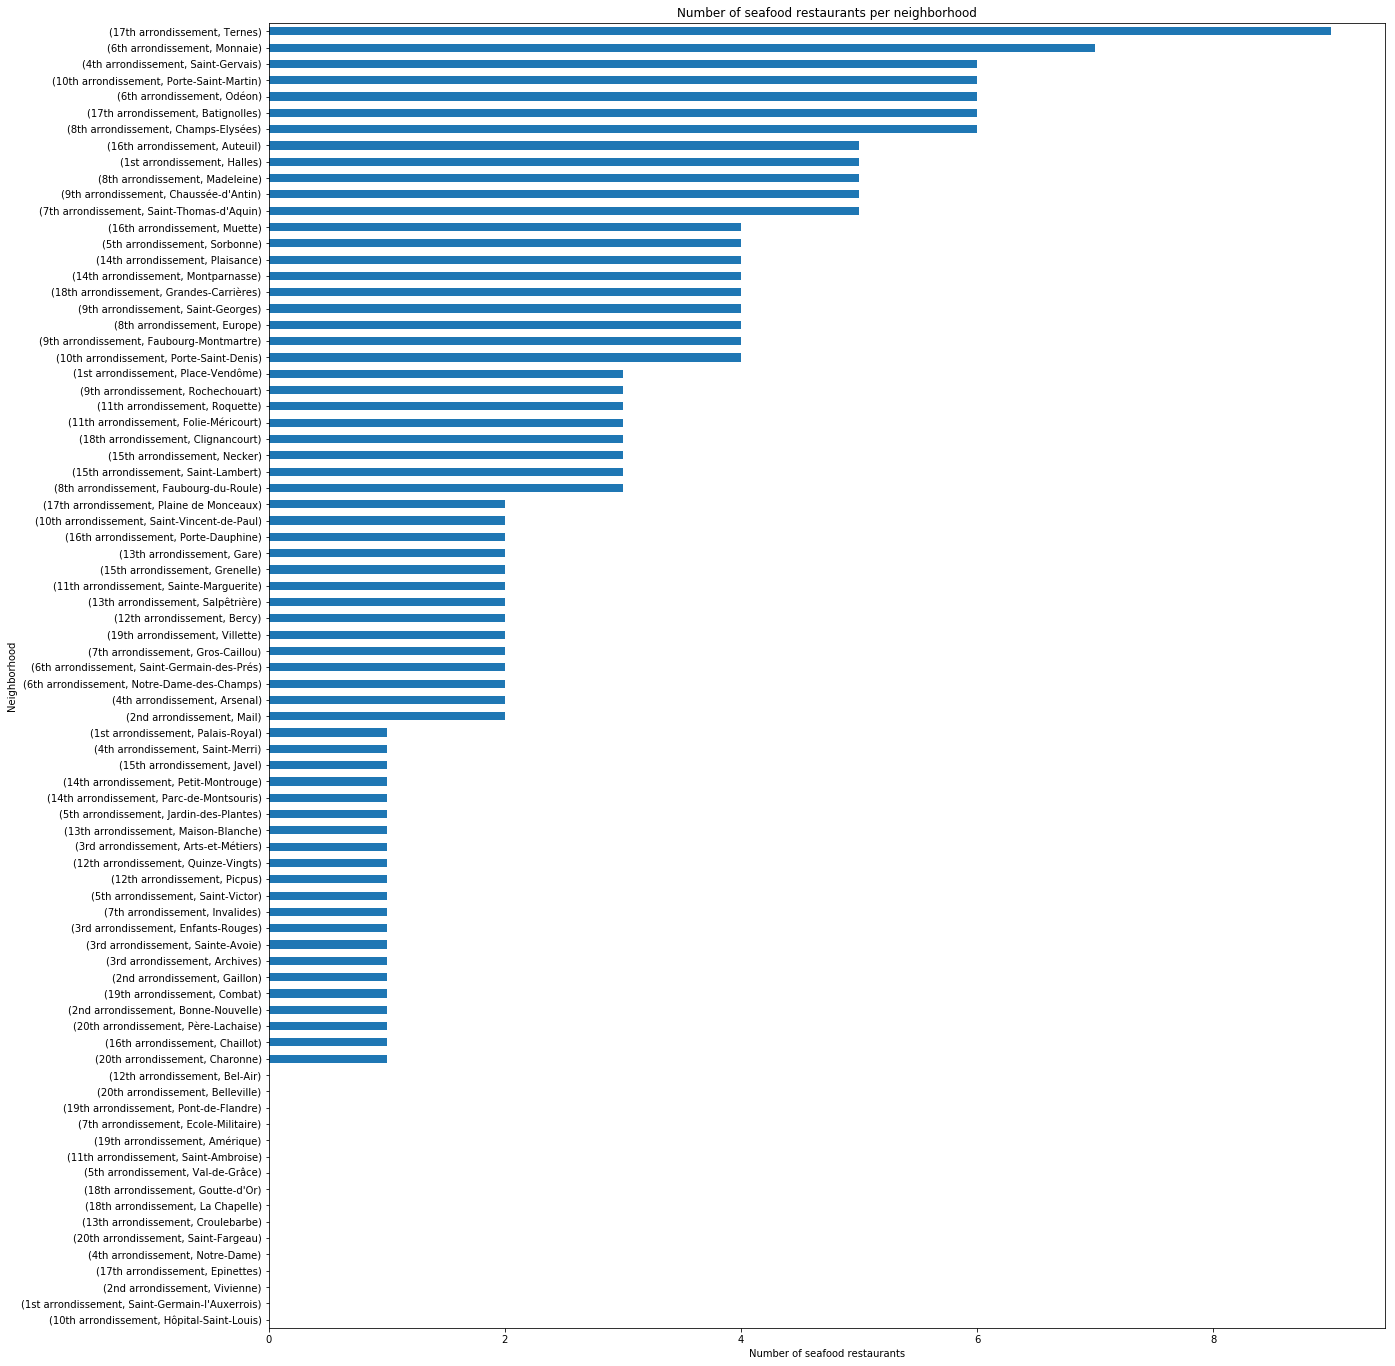

In [54]:
bar_chart_neighborhood_df.plot(kind='barh', figsize=(20, 24))

plt.xlabel('Number of ' + RESTAURANT_CATEGORY + ' restaurants')
plt.ylabel('Neighborhood')
plt.title('Number of ' + RESTAURANT_CATEGORY + ' restaurants per neighborhood')
plt.legend().remove()

plt.show()

##### Bar chart of the number of restaurants per neighborhood and per million inhabitants

Create a new dataframe with all the neighborhood data.

In [55]:
bar_chart_neighborhood_df2 = pd.merge(bar_chart_neighborhood_df, paris_neighborhoods, on='Neighborhood')
bar_chart_neighborhood_df2 = bar_chart_neighborhood_df2[['Neighborhood', 'RestaurantsCount', 'District', 'Population']]

print('The dataframe shape is {}.'.format(bar_chart_neighborhood_df2.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_neighborhood_df2.dtypes))
bar_chart_neighborhood_df2.head()

The dataframe shape is (80, 4).
The dataframe types are:
Neighborhood        object
RestaurantsCount     int64
District            object
Population           int64
dtype: object.


Neighborhood  RestaurantsCount             District  \
0        Hôpital-Saint-Louis                 0  10th arrondissement   
1  Saint-Germain-l'Auxerrois                 0   1st arrondissement   
2                   Vivienne                 0   2nd arrondissement   
3                  Epinettes                 0  17th arrondissement   
4                 Notre-Dame                 0   4th arrondissement   

   Population  
0       29870  
1        1672  
2        2917  
3       44352  
4        4087

Calculate the number of restaurants per million inhabitants.

In [56]:
bar_chart_neighborhood_df2['RestaurantsPerMillionInhabitants'] = bar_chart_neighborhood_df2['RestaurantsCount'] / bar_chart_neighborhood_df2['Population'] * 1e6
bar_chart_neighborhood_df2 = bar_chart_neighborhood_df2[['Neighborhood', 'RestaurantsPerMillionInhabitants', 'District']]
bar_chart_neighborhood_df2.set_index(['District', 'Neighborhood'], inplace=True)

print('The dataframe shape is {}.'.format(bar_chart_neighborhood_df2.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_neighborhood_df2.dtypes))
bar_chart_neighborhood_df2.head()

The dataframe shape is (80, 1).
The dataframe types are:
RestaurantsPerMillionInhabitants    float64
dtype: object.


RestaurantsPerMillionInhabitants
District            Neighborhood                                               
10th arrondissement Hôpital-Saint-Louis                                     0.0
1st arrondissement  Saint-Germain-l'Auxerrois                               0.0
2nd arrondissement  Vivienne                                                0.0
17th arrondissement Epinettes                                               0.0
4th arrondissement  Notre-Dame                                              0.0

Sort the dataframe by number of restaurants for a nicer bar chart.

In [57]:
bar_chart_neighborhood_df2 = bar_chart_neighborhood_df2.sort_values(by=['RestaurantsPerMillionInhabitants'], ascending=True)

print('The dataframe shape is {}.'.format(bar_chart_neighborhood_df2.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_neighborhood_df2.dtypes))
bar_chart_neighborhood_df2.head()

The dataframe shape is (80, 1).
The dataframe types are:
RestaurantsPerMillionInhabitants    float64
dtype: object.


RestaurantsPerMillionInhabitants
District            Neighborhood                                         
10th arrondissement Hôpital-Saint-Louis                               0.0
12th arrondissement Bel-Air                                           0.0
20th arrondissement Belleville                                        0.0
19th arrondissement Pont-de-Flandre                                   0.0
7th arrondissement  Ecole-Militaire                                   0.0

Draw the bar chart.

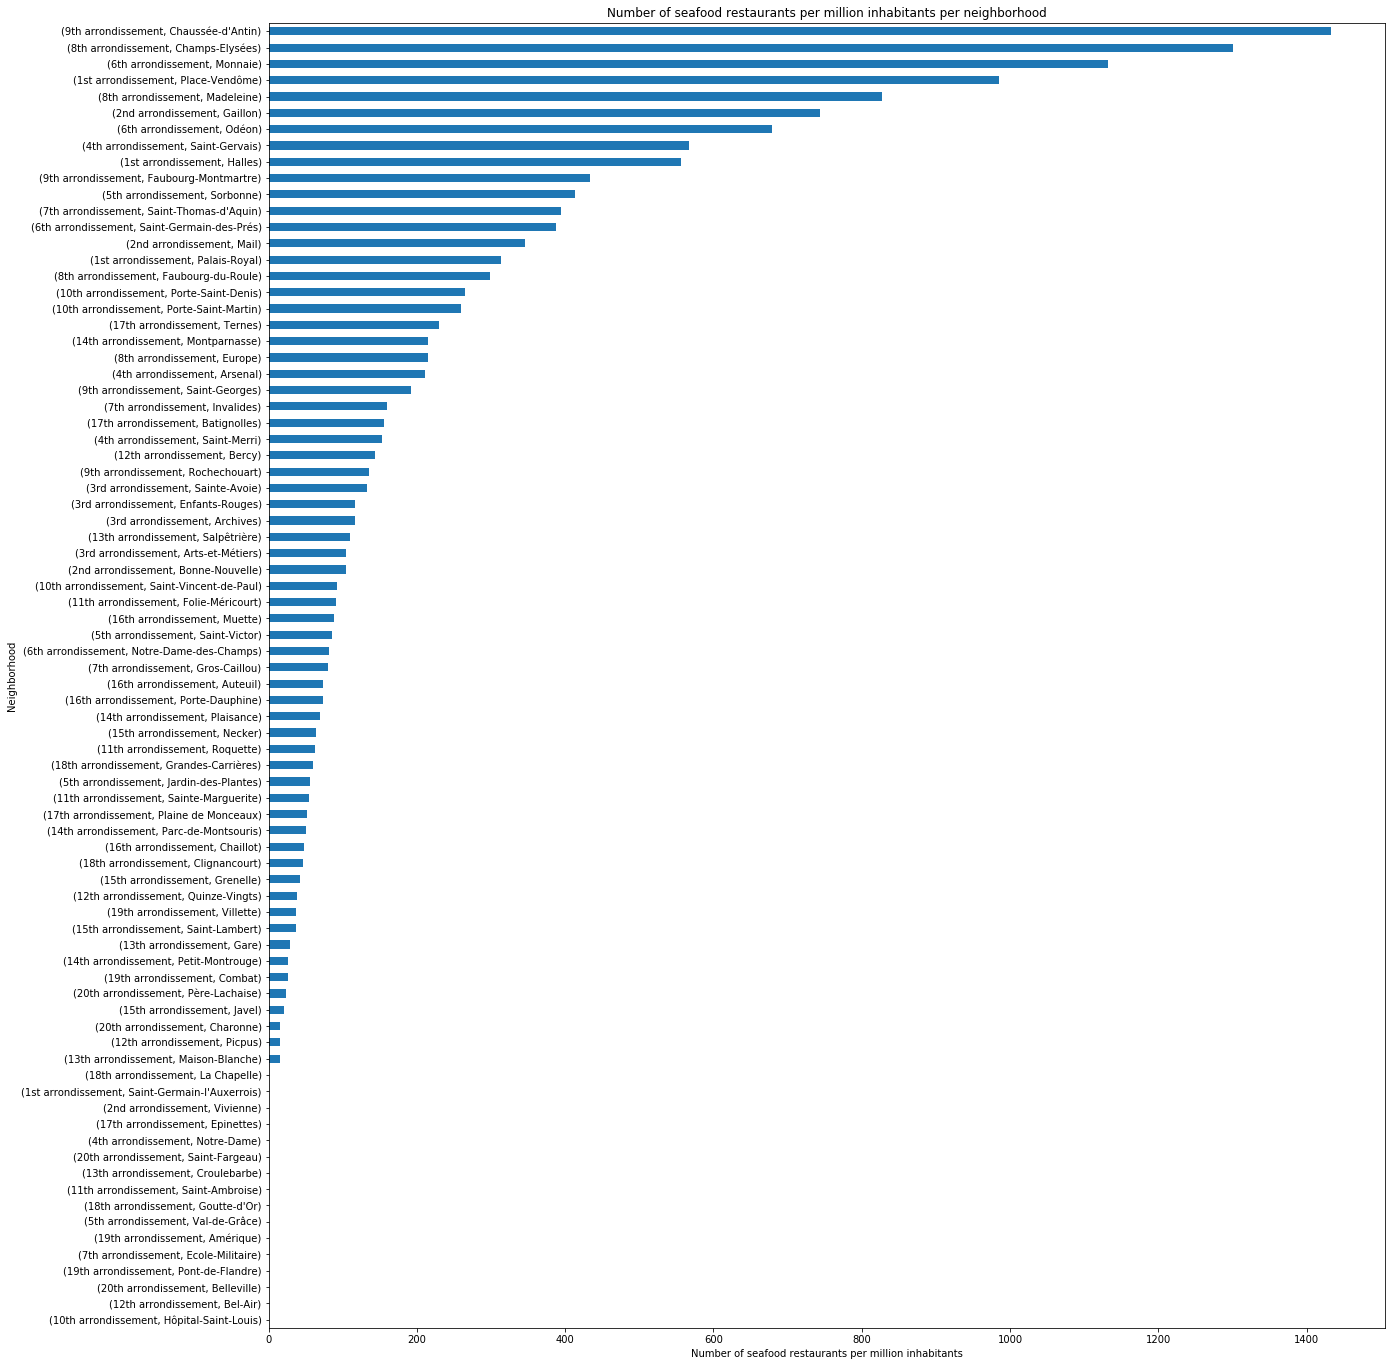

In [58]:
bar_chart_neighborhood_df2.plot(kind='barh', figsize=(20, 24))

plt.xlabel('Number of ' + RESTAURANT_CATEGORY + ' restaurants per million inhabitants')
plt.ylabel('Neighborhood')
plt.title('Number of ' + RESTAURANT_CATEGORY + ' restaurants per million inhabitants per neighborhood')
plt.legend().remove()

plt.show()

##### Bar chart of the number of restaurants per neighborhood

Create a new dataframe with the number of restaurants by District.

In [59]:
bar_chart_district_df = bar_chart_df.groupby(['District']).count()
bar_chart_district_df.rename(columns={'id': 'RestaurantsCount'}, inplace=True)

print('The dataframe shape is {}.'.format(bar_chart_district_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_district_df.dtypes))
bar_chart_district_df.head()

The dataframe shape is (20, 1).
The dataframe types are:
RestaurantsCount    int64
dtype: object.


RestaurantsCount
District                             
10th arrondissement                12
11th arrondissement                 8
12th arrondissement                 4
13th arrondissement                 5
14th arrondissement                10

Sort by number of restaurant for a nicer bar chart.

In [60]:
bar_chart_district_df = bar_chart_district_df.sort_values(by=['RestaurantsCount'], ascending=True)

print('The dataframe shape is {}.'.format(bar_chart_district_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_district_df.dtypes))
bar_chart_district_df.head()

The dataframe shape is (20, 1).
The dataframe types are:
RestaurantsCount    int64
dtype: object.


RestaurantsCount
District                             
20th arrondissement                 2
19th arrondissement                 3
12th arrondissement                 4
2nd arrondissement                  4
3rd arrondissement                  4

Draw the bar chart.

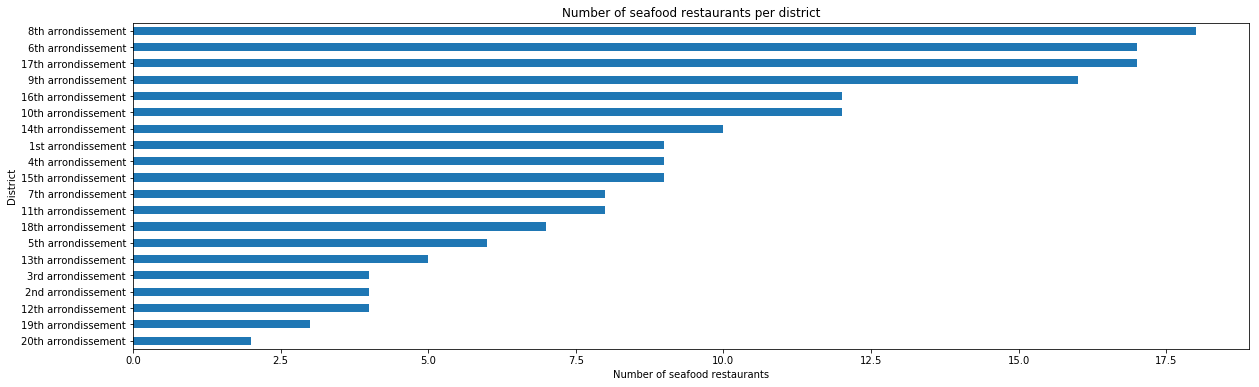

In [61]:
bar_chart_district_df.plot(kind='barh', figsize=(20, 6))

plt.xlabel('Number of ' + RESTAURANT_CATEGORY + ' restaurants')
plt.ylabel('District')
plt.title('Number of ' + RESTAURANT_CATEGORY + ' restaurants per district')
plt.legend().remove()

plt.show()

##### Bar chart of the number of restaurants per district and per million inhabitants

Create a new dataframe with all the data from neighborhoods.

In [62]:
bar_chart_district_df2 = pd.merge(bar_chart_neighborhood_df, paris_neighborhoods, on='Neighborhood', how='outer')
bar_chart_district_df2 = bar_chart_district_df2[['RestaurantsCount', 'District', 'Population']]

print('The dataframe shape is {}.'.format(bar_chart_district_df2.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_district_df2.dtypes))
bar_chart_district_df2.head()

The dataframe shape is (80, 3).
The dataframe types are:
RestaurantsCount     int64
District            object
Population           int64
dtype: object.


RestaurantsCount             District  Population
0                 0  10th arrondissement       29870
1                 0   1st arrondissement        1672
2                 0   2nd arrondissement        2917
3                 0  17th arrondissement       44352
4                 0   4th arrondissement        4087

Group the dataframe by District and calculate the number of restaurants per million inhabitants.

In [63]:
bar_chart_district_df2 = bar_chart_district_df2.groupby(['District']).sum()
bar_chart_district_df2['RestaurantsPerMillionInhabitants'] = bar_chart_district_df2['RestaurantsCount'] / bar_chart_district_df2['Population'] * 1e6
bar_chart_district_df2 = bar_chart_district_df2[['RestaurantsPerMillionInhabitants']]

print('The dataframe shape is {}.'.format(bar_chart_district_df2.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_district_df2.dtypes))
bar_chart_district_df2.head()

The dataframe shape is (20, 1).
The dataframe types are:
RestaurantsPerMillionInhabitants    float64
dtype: object.


RestaurantsPerMillionInhabitants
District                                             
10th arrondissement                        133.801639
11th arrondissement                         53.631525
12th arrondissement                         29.269292
13th arrondissement                         29.141435
14th arrondissement                         75.288732

Sort the dataframe by number of restaurants for a nicer bar chart.

In [64]:
bar_chart_district_df2 = bar_chart_district_df2.sort_values(by=['RestaurantsPerMillionInhabitants'], ascending=True)

print('The dataframe shape is {}.'.format(bar_chart_district_df2.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_district_df2.dtypes))
bar_chart_district_df2.head()

The dataframe shape is (20, 1).
The dataframe types are:
RestaurantsPerMillionInhabitants    float64
dtype: object.


RestaurantsPerMillionInhabitants
District                                             
20th arrondissement                         10.923411
19th arrondissement                         17.382538
13th arrondissement                         29.141435
12th arrondissement                         29.269292
18th arrondissement                         37.923730

Draw the bar chart.

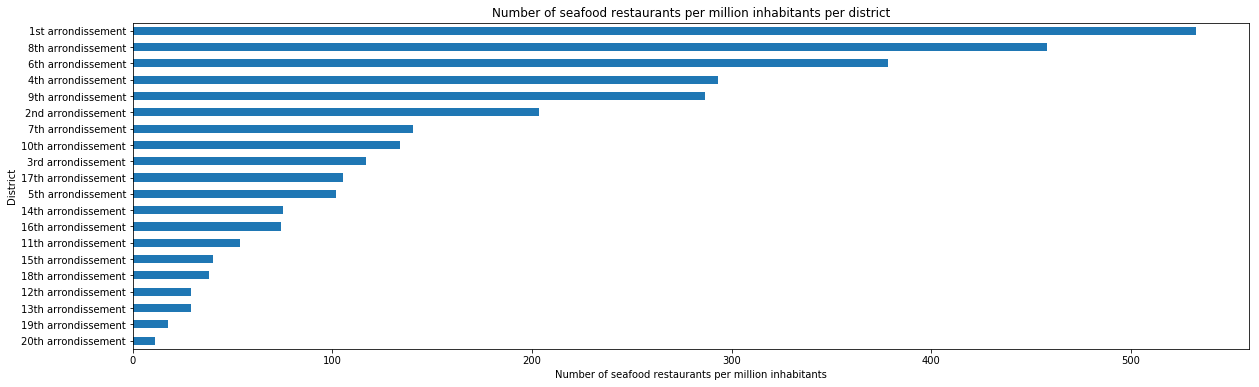

In [65]:
bar_chart_district_df2.plot(kind='barh', figsize=(20, 6))

plt.xlabel('Number of ' + RESTAURANT_CATEGORY + ' restaurants per million inhabitants')
plt.ylabel('District')
plt.title('Number of ' + RESTAURANT_CATEGORY + ' restaurants per million inhabitants per district')
plt.legend().remove()

plt.show()

## 4. Get more details regarding restaurants

### Get the data from Foursquare

#### Import the data

Get the details of restaurants in Paris we obtained earlier from Foursquare.

In [66]:
restaurants_paris_details = pd.DataFrame(columns=['id', 'Name', 'Latitude', 'Longitude', 'Price', 'PriceDescription', 'Rating', 'Likes', 'TipsCount', 'IsPrimaryCategory', 'NeighborhoodCode'])
foursquare_error = False

#Get the list of restaurants from IBM Cloud (we saved it earlier)
restaurants_paris_file = project.get_file(RESTAURANT_CATEGORY+'_restaurants_paris.csv')
restaurants_paris = pd.read_csv(restaurants_paris_file, encoding='utf-8')
print('File ' + RESTAURANT_CATEGORY + '_restaurants_paris.csv loaded.')

if FOURSQUARE_UPDATE:
    #If we decided to update data from Foursquare (to parameterized in the constants at the beginning of the file)
    #For each restaurant
    for restaurant_id, restaurant in restaurants_paris.iterrows():
        restaurant_details = get_foursquare_venue_details(restaurant['id'], FOURSQUARE_CATEGORY) #Obtain the detail of the restaurant from Foursquare
        if restaurant_details is None:
            #If Foursquare returned an error (website down, quota reached...), change the foursquare_error variable and stop the loop
            foursquare_error = True
            break
        #Add the detail of the restaurants to the list of all restaurants
        restaurants_paris_details = restaurants_paris_details.append({'id': restaurant['id'], 'Name': restaurant_details['Name'], 'Latitude': restaurant['Latitude'], 'Longitude': restaurant['Longitude'], 'Price': restaurant_details['Price'], 'PriceDescription': restaurant_details['PriceDescription'], 'Rating': restaurant_details['Rating'], 'Likes': restaurant_details['Likes'], 'TipsCount': restaurant_details['TipsCount'], 'IsPrimaryCategory': restaurant_details['IsPrimaryCategory'], 'NeighborhoodCode': restaurant['NeighborhoodCode']}, ignore_index=True, sort=False)
    
    if foursquare_error:
        #If Foursquare returned an error (website down, quota reached...), we obtain the data from IBM Cloud  (data obtained previously from Foursquare, may not be up to date).
        restaurants_paris_details_file = project.get_file(RESTAURANT_CATEGORY+'_restaurants_paris_details_foursquare.csv')
        restaurants_paris_details = pd.read_csv(restaurants_paris_details_file, encoding='utf-8')
        print('File ' + RESTAURANT_CATEGORY + '_restaurants_paris_details_foursquare.csv loaded.')
    else:
        #If there was no error, save data to IBM Cloud
        project.save_data(file_name=RESTAURANT_CATEGORY+'_restaurants_paris_details_foursquare.csv', data=restaurants_paris_details.to_csv(index=False, encoding='utf-8'), overwrite=True)
        print('File ' + RESTAURANT_CATEGORY + '_restaurants_paris_details_foursquare.csv saved.')
else:
    #If we decided to get the data from IBM Cloud (data obtained previously from Foursquare, may not be up to date but avoid to reach the maximum of Foursquare queries).
    restaurants_paris_details_file = project.get_file(RESTAURANT_CATEGORY+'_restaurants_paris_details_foursquare.csv')
    restaurants_paris_details = pd.read_csv(restaurants_paris_details_file, encoding='utf-8')
    print('File ' + RESTAURANT_CATEGORY + '_restaurants_paris_details_foursquare.csv loaded.')

restaurants_paris_details = restaurants_paris_details.astype({'IsPrimaryCategory': bool})
    
print('The dataframe shape is {}.'.format(restaurants_paris_details.shape))
print('The dataframe types are:\n{}.'.format(restaurants_paris_details.dtypes))
restaurants_paris_details.head()

File seafood_restaurants_paris.csv loaded.
File seafood_restaurants_paris_details_foursquare.csv loaded.
The dataframe shape is (180, 11).
The dataframe types are:
id                    object
Name                  object
Latitude             float64
Longitude            float64
Price                float64
PriceDescription      object
Rating               float64
Likes                  int64
TipsCount              int64
IsPrimaryCategory       bool
NeighborhoodCode       int64
dtype: object.


id                   Name   Latitude  Longitude  \
0  4ea456aa61af76b39d5803a1      La Belle de Liron  48.866846   2.347244   
1  4b5ff171f964a5204cd129e3          Nautilus Food  48.872344   2.342870   
2  4bd2011c046076b0bb017371      Léon de Bruxelles  48.883684   2.327870   
3  4b8137c8f964a520e09a30e3               La Criée  48.870531   2.348942   
4  56b8e71c498e33f2f695cd55  Restaurant Le Sichuan  48.870730   2.355052   

   Price PriceDescription  Rating  Likes  TipsCount  IsPrimaryCategory  \
0    3.0        Expensive     NaN      0          0               True   
1    3.0        Expensive     NaN      0          0               True   
2    3.0        Expensive     6.9     46         19               True   
3    3.0        Expensive     7.9     28          9               True   
4    3.0        Expensive     NaN      0          0               True   

   NeighborhoodCode  
0           7510203  
1           7510903  
2           7511801  
3           7511002  
4           7511003

Statistics regarding the dataframe of restaurants.

In [67]:
restaurants_paris_details.describe()

Latitude   Longitude       Price     Rating       Likes   TipsCount  \
count  180.000000  180.000000  177.000000  89.000000  180.000000  180.000000   
mean    48.862305    2.332510    2.932203   7.597753   27.111111   10.544444   
std      0.015727    0.028807    0.312490   0.762618   66.871919   21.642685   
min     48.820640    2.264493    1.000000   5.900000    0.000000    0.000000   
25%     48.851690    2.317504    3.000000   7.100000    1.000000    0.000000   
50%     48.863556    2.334557    3.000000   7.600000    5.000000    2.000000   
75%     48.874403    2.352560    3.000000   8.100000   24.250000   10.250000   
max     48.891317    2.407587    3.000000   9.000000  709.000000  203.000000   

       NeighborhoodCode  
count      1.800000e+02  
mean       7.511025e+06  
std        5.115693e+02  
min        7.510102e+06  
25%        7.510603e+06  
50%        7.510904e+06  
75%        7.511502e+06  
max        7.512004e+06

### Visualize the data

#### Map representing the rating, the price and whether seafood is their primary category for each restaurant

Obtain the GeoJSON from IBM Cloud.

In [68]:
paris_neighborhoods_geo_file = project.get_file('paris_neighborhoods_geo.json')
paris_neighborhoods_geo = pd.read_json(paris_neighborhoods_geo_file)
print('File paris_neighborhoods_geo.json loaded.')

paris_neighborhoods_geo = r'paris_neighborhoods_geo.json'

File paris_neighborhoods_geo.json loaded.


Draw the map.

In [69]:
restaurants_details_map = folium.Map(location=PARIS_COORDINATES, zoom_start=13, tiles='OpenStreetMap')

folium.GeoJson(
    data=paris_neighborhoods_geo,
    style_function=lambda x: {'color': 'grey', 'opacity': 0.5, 'weight': 2, 'fillColor': 'grey', 'fill_opacity': 0.05},
    tooltip=folium.GeoJsonTooltip(fields=(['l_qu']),labels=False)
).add_to(restaurants_details_map)

for latitude, longitude, name, price, rating, isPrimaryCategory in restaurants_paris_details[['Latitude', 'Longitude', 'Name', 'Price', 'Rating', 'IsPrimaryCategory']].values:
    restaurants_details_map.add_child(
        folium.CircleMarker(
            [latitude, longitude],
            radius=5 if np.isnan(rating) else rating,
            color='gold',
            opacity=1 if isPrimaryCategory else 0,
            fill=True,
            fill_color='green' if price==1 else 'yellow' if price==2 else 'orange' if price==3 else 'red' if price==4 else 'grey',
            fill_opacity=0.8,
            popup=name
        )
    )

restaurants_details_map

#### Scatter plot of price vs rating

Create a new data frame with only the price and the rating for each restaurant.

In [70]:
scatter_plot_neighborhood_df = pd.merge(paris_neighborhoods[['NeighborhoodCode', 'Neighborhood', 'District',]], restaurants_paris_details[['NeighborhoodCode', 'Price', 'Rating']], on='NeighborhoodCode', how='outer')
scatter_plot_neighborhood_df.drop(['NeighborhoodCode'], axis='columns', inplace=True)
scatter_plot_neighborhood_df.set_index(['District', 'Neighborhood'], inplace=True)

print('The dataframe shape is {}.'.format(scatter_plot_neighborhood_df.shape))
print('The dataframe types are:\n{}.'.format(scatter_plot_neighborhood_df.dtypes))
scatter_plot_neighborhood_df.head()

The dataframe shape is (196, 2).
The dataframe types are:
Price     float64
Rating    float64
dtype: object.


Price  Rating
District           Neighborhood               
6th arrondissement Monnaie         3.0     7.6
                   Monnaie         3.0     8.6
                   Monnaie         2.0     8.0
                   Monnaie         3.0     NaN
                   Monnaie         3.0     NaN

Drop the line with empty price or rating.

In [71]:
scatter_plot_neighborhood_df2 = scatter_plot_neighborhood_df.dropna(subset=['Price', 'Rating']).copy()

print('The dataframe shape is {}.'.format(scatter_plot_neighborhood_df2.shape))
print('The dataframe types are:\n{}.'.format(scatter_plot_neighborhood_df2.dtypes))
scatter_plot_neighborhood_df2.head()

The dataframe shape is (86, 2).
The dataframe types are:
Price     float64
Rating    float64
dtype: object.


Price  Rating
District           Neighborhood               
6th arrondissement Monnaie         3.0     7.6
                   Monnaie         3.0     8.6
                   Monnaie         2.0     8.0
                   Odéon           3.0     8.7
                   Odéon           3.0     8.3

Draw the scatter plot.

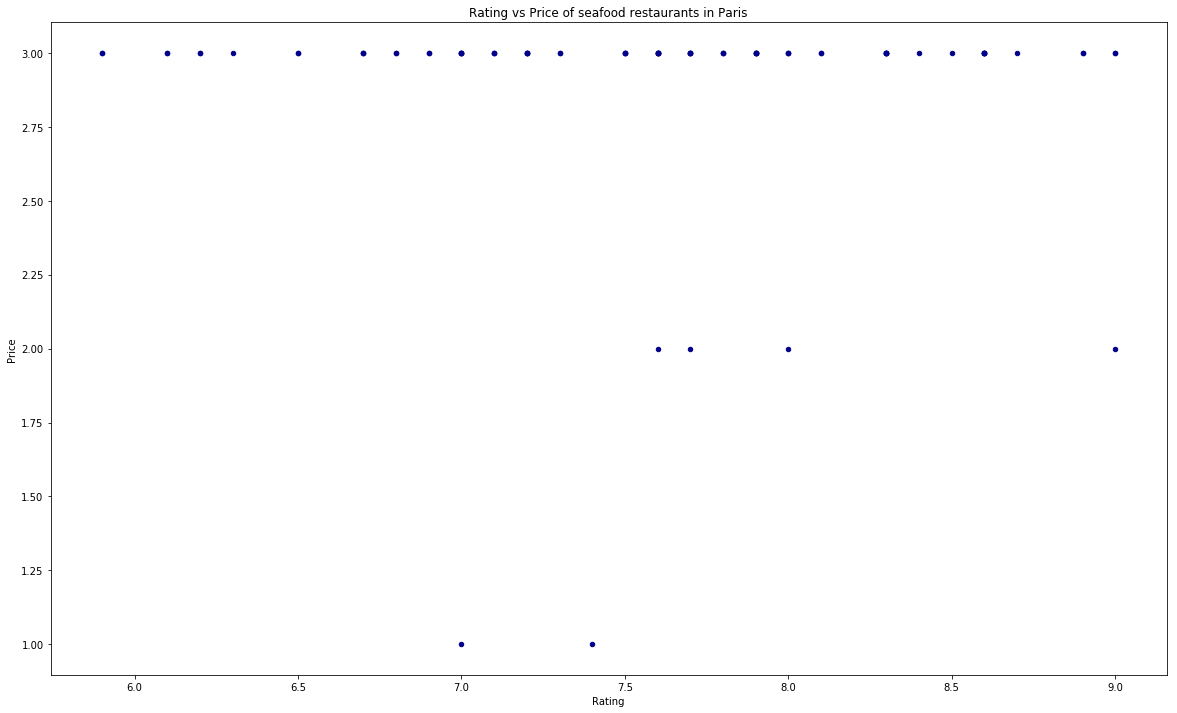

In [72]:
scatter_plot_neighborhood_df2.plot(kind='scatter', x='Rating', y='Price', figsize=(20, 12), color='darkblue')

plt.title('Rating vs Price of ' + RESTAURANT_CATEGORY + ' restaurants in Paris')
plt.xlabel('Rating')
plt.ylabel('Price')

plt.show()

### Bar chart of the average rating of restaurants per neighborhood

Create a new dataframe grouped by neighborhood.

In [73]:
bar_chart_df = scatter_plot_neighborhood_df.groupby(['District', 'Neighborhood']).mean()

print('The dataframe shape is {}.'.format(bar_chart_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_df.dtypes))
bar_chart_df.head()

The dataframe shape is (80, 2).
The dataframe types are:
Price     float64
Rating    float64
dtype: object.


Price  Rating
District            Neighborhood                           
10th arrondissement Hôpital-Saint-Louis         NaN     NaN
                    Porte-Saint-Denis      3.000000    7.55
                    Porte-Saint-Martin     2.666667    8.20
                    Saint-Vincent-de-Paul  3.000000    8.30
11th arrondissement Folie-Méricourt        2.333333    6.50

Create a new dataframe with only the rating and drop the empty lines.

In [74]:
bar_chart_neighborhood_rating_df = bar_chart_df[['Rating']].copy()
bar_chart_neighborhood_rating_df.dropna(subset=['Rating'], inplace=True)

print('The dataframe shape is {}.'.format(bar_chart_neighborhood_rating_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_neighborhood_rating_df.dtypes))
bar_chart_neighborhood_rating_df.head()

The dataframe shape is (45, 1).
The dataframe types are:
Rating    float64
dtype: object.


Rating
District            Neighborhood                 
10th arrondissement Porte-Saint-Denis        7.55
                    Porte-Saint-Martin       8.20
                    Saint-Vincent-de-Paul    8.30
11th arrondissement Folie-Méricourt          6.50
                    Roquette                 8.90

Sort the dataframe for a nicer bar chart.

In [75]:
bar_chart_neighborhood_rating_df = bar_chart_neighborhood_rating_df.sort_values(by=['Rating'], ascending=True)

print('The dataframe shape is {}.'.format(bar_chart_neighborhood_rating_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_neighborhood_rating_df.dtypes))
bar_chart_neighborhood_rating_df.head()

The dataframe shape is (45, 1).
The dataframe types are:
Rating    float64
dtype: object.


Rating
District            Neighborhood             
11th arrondissement Sainte-Marguerite    5.90
3rd arrondissement  Archives             6.20
15th arrondissement Necker               6.45
11th arrondissement Folie-Méricourt      6.50
15th arrondissement Saint-Lambert        6.75

Draw the bar chart.

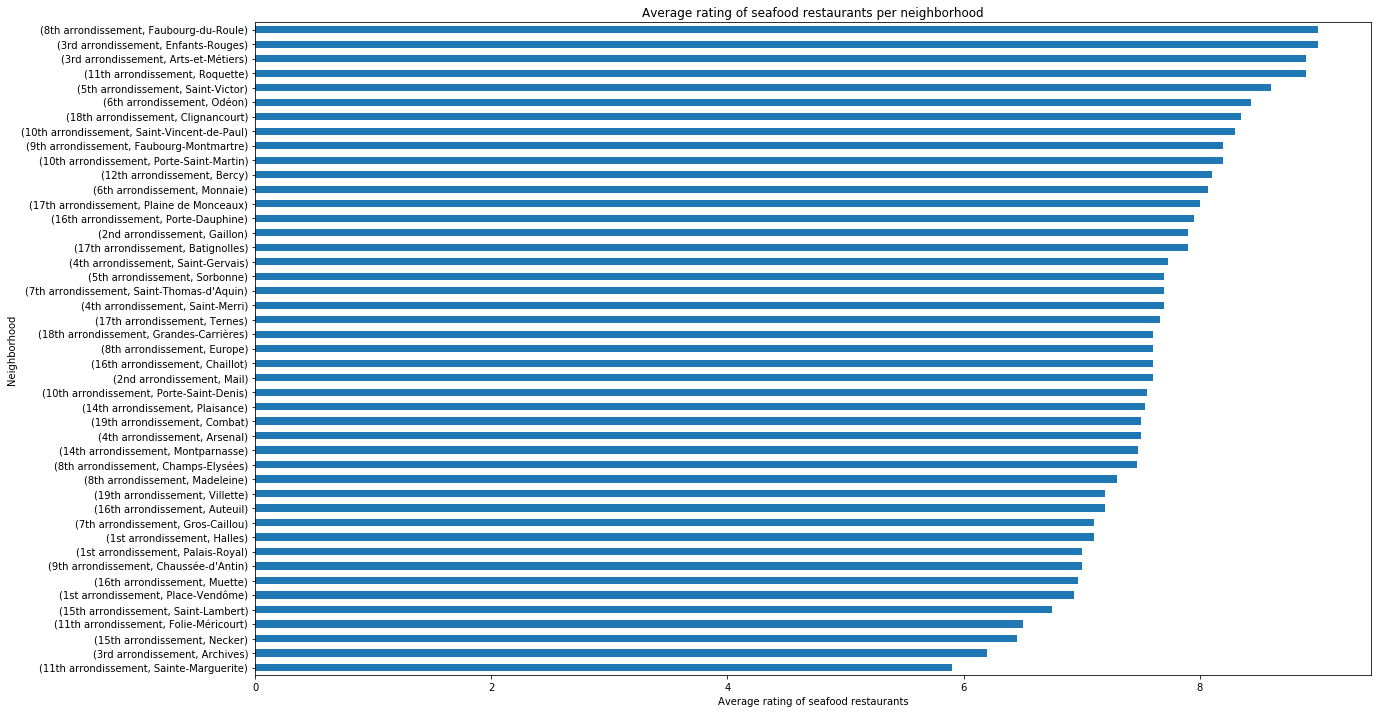

In [76]:
bar_chart_neighborhood_rating_df.plot(kind='barh', figsize=(20, 12))

plt.xlabel('Average rating of ' + RESTAURANT_CATEGORY + ' restaurants')
plt.ylabel('Neighborhood')
plt.title('Average rating of ' + RESTAURANT_CATEGORY + ' restaurants per neighborhood')
plt.legend().remove()

plt.show()

### Bar chart of the average price of restaurants per neighborhood

Create a new dataframe with only the price and drop the empty lines.

In [77]:
bar_chart_neighborhood_price_df = bar_chart_df[['Price']].copy()
bar_chart_neighborhood_price_df.dropna(subset=['Price'], inplace=True)

print('The dataframe shape is {}.'.format(bar_chart_neighborhood_price_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_neighborhood_price_df.dtypes))
bar_chart_neighborhood_price_df.head()

The dataframe shape is (64, 1).
The dataframe types are:
Price    float64
dtype: object.


Price
District            Neighborhood                   
10th arrondissement Porte-Saint-Denis      3.000000
                    Porte-Saint-Martin     2.666667
                    Saint-Vincent-de-Paul  3.000000
11th arrondissement Folie-Méricourt        2.333333
                    Roquette               2.666667

Sort the dataframe for a nicer bar chart.

In [78]:
bar_chart_neighborhood_price_df = bar_chart_neighborhood_price_df.sort_values(by=['Price'], ascending=True)

print('The dataframe shape is {}.'.format(bar_chart_neighborhood_price_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_neighborhood_price_df.dtypes))
bar_chart_neighborhood_price_df.head()

The dataframe shape is (64, 1).
The dataframe types are:
Price    float64
dtype: object.


Price
District            Neighborhood             
12th arrondissement Quinze-Vingts    2.000000
3rd arrondissement  Enfants-Rouges   2.000000
11th arrondissement Folie-Méricourt  2.333333
14th arrondissement Montparnasse     2.333333
12th arrondissement Bercy            2.500000

Draw the bar chart.

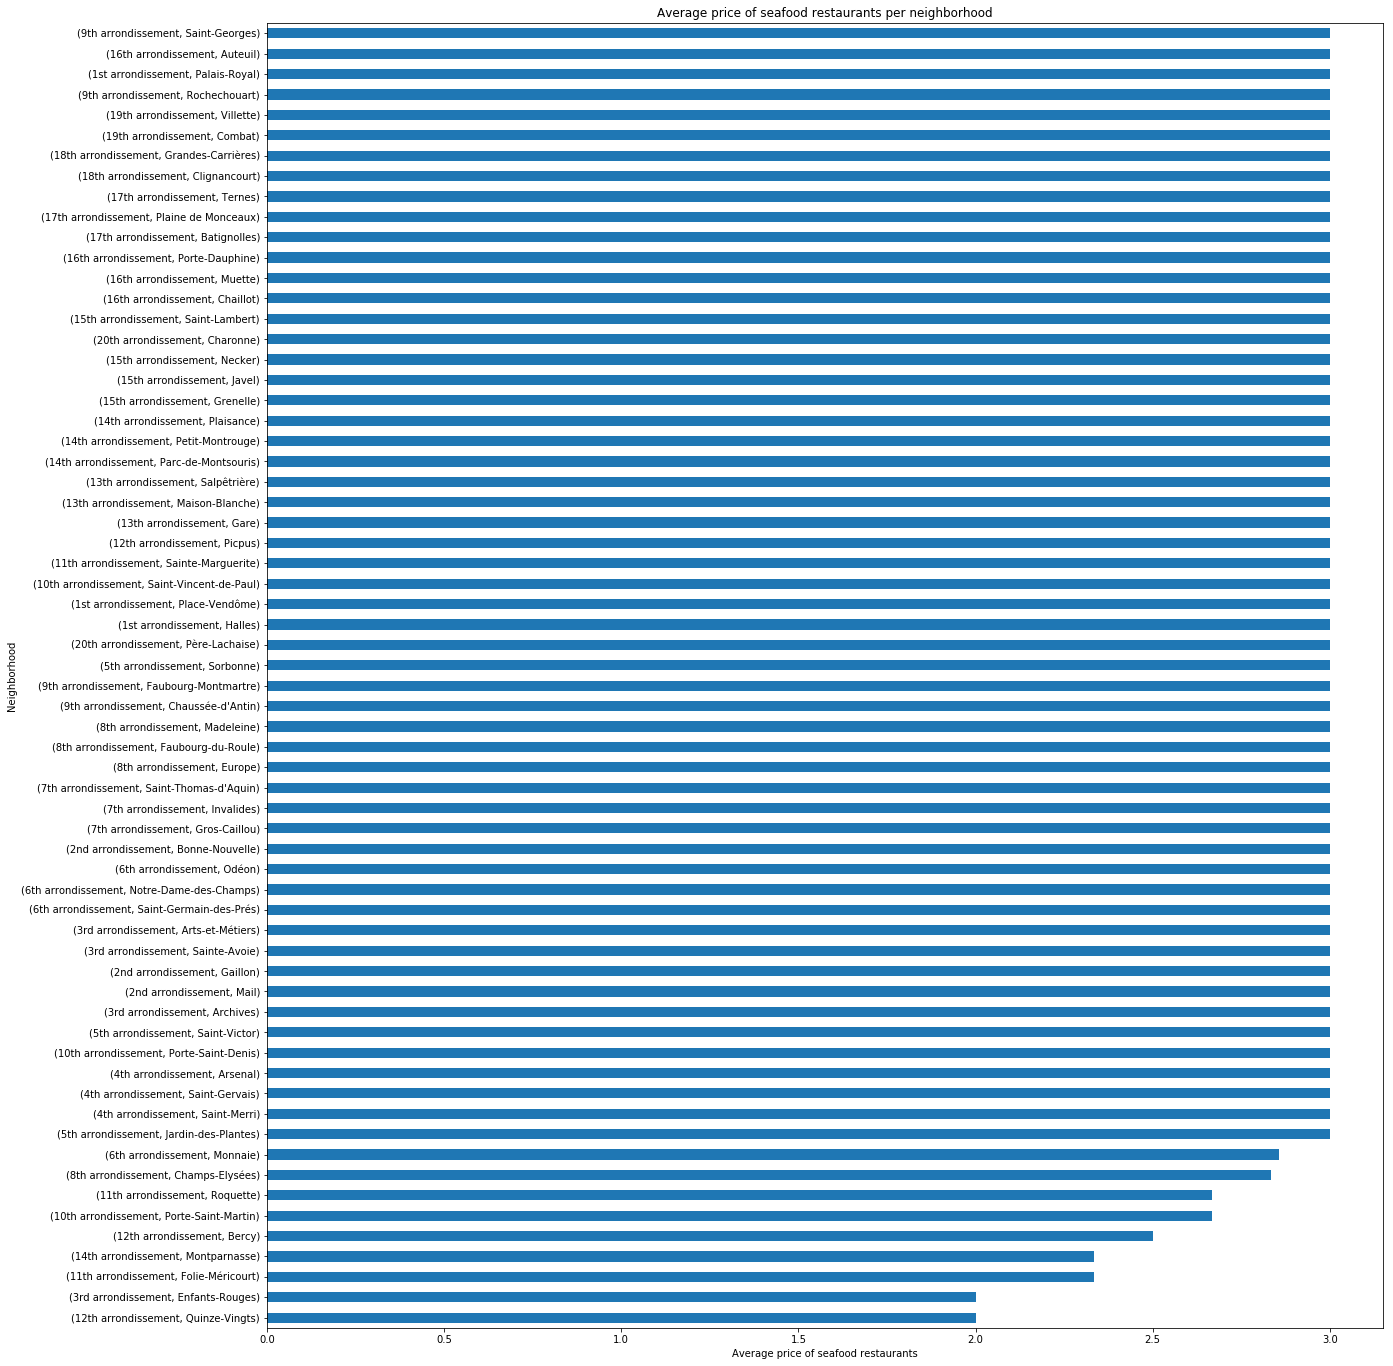

In [79]:
bar_chart_neighborhood_price_df.plot(kind='barh', figsize=(20, 24))

plt.xlabel('Average price of ' + RESTAURANT_CATEGORY + ' restaurants')
plt.ylabel('Neighborhood')
plt.title('Average price of ' + RESTAURANT_CATEGORY + ' restaurants per neighborhood')
plt.legend().remove()

plt.show()

### Bar chart of the average rating of restaurants per district

Create a new dataframe grouped by district.

In [80]:
bar_chart_district_df = scatter_plot_neighborhood_df.groupby(['District']).mean()

print('The dataframe shape is {}.'.format(bar_chart_district_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_district_df.dtypes))
bar_chart_district_df.head()

The dataframe shape is (20, 2).
The dataframe types are:
Price     float64
Rating    float64
dtype: object.


Price    Rating
District                               
10th arrondissement  2.833333  7.842857
11th arrondissement  2.625000  7.100000
12th arrondissement  2.500000  8.100000
13th arrondissement  3.000000       NaN
14th arrondissement  2.777778  7.500000

Create a new dataframe with only the rating and drop the empty lines.

In [81]:
bar_chart_district_rating_df = bar_chart_district_df[['Rating']].copy()
bar_chart_district_rating_df.dropna(subset=['Rating'], inplace=True)

print('The dataframe shape is {}.'.format(bar_chart_district_rating_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_district_rating_df.dtypes))
bar_chart_district_rating_df.head()

The dataframe shape is (18, 1).
The dataframe types are:
Rating    float64
dtype: object.


Rating
District                     
10th arrondissement  7.842857
11th arrondissement  7.100000
12th arrondissement  8.100000
14th arrondissement  7.500000
15th arrondissement  6.600000

Sort the dataframe for a nicer bar chart.

In [82]:
bar_chart_district_rating_df = bar_chart_district_rating_df.sort_values(by=['Rating'], ascending=True)

print('The dataframe shape is {}.'.format(bar_chart_district_rating_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_district_rating_df.dtypes))
bar_chart_district_rating_df.head()

The dataframe shape is (18, 1).
The dataframe types are:
Rating    float64
dtype: object.


Rating
District                     
15th arrondissement  6.600000
1st arrondissement   7.000000
11th arrondissement  7.100000
19th arrondissement  7.300000
16th arrondissement  7.371429

Draw the bar chart.

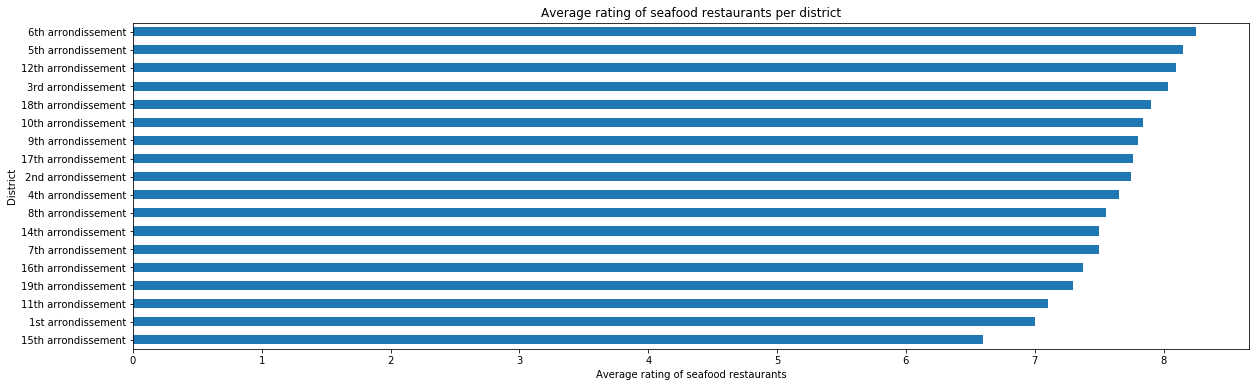

In [83]:
bar_chart_district_rating_df.plot(kind='barh', figsize=(20, 6))

plt.xlabel('Average rating of ' + RESTAURANT_CATEGORY + ' restaurants')
plt.ylabel('District')
plt.title('Average rating of ' + RESTAURANT_CATEGORY + ' restaurants per district')
plt.legend().remove()

plt.show()

### Bar chart of the average price of restaurants per district

Create a new dataframe with only the price and drop the empty lines.

In [84]:
bar_chart_district_price_df = bar_chart_district_df[['Price']].copy()
bar_chart_district_price_df.dropna(subset=['Price'], inplace=True)

print('The dataframe shape is {}.'.format(bar_chart_district_price_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_district_price_df.dtypes))
bar_chart_district_price_df.head()

The dataframe shape is (20, 1).
The dataframe types are:
Price    float64
dtype: object.


Price
District                     
10th arrondissement  2.833333
11th arrondissement  2.625000
12th arrondissement  2.500000
13th arrondissement  3.000000
14th arrondissement  2.777778

Sort the dataframe for a nicer bar chart.

In [85]:
bar_chart_district_price_df = bar_chart_district_price_df.sort_values(by=['Price'], ascending=True)

print('The dataframe shape is {}.'.format(bar_chart_district_price_df.shape))
print('The dataframe types are:\n{}.'.format(bar_chart_district_price_df.dtypes))
bar_chart_district_price_df.head()

The dataframe shape is (20, 1).
The dataframe types are:
Price    float64
dtype: object.


Price
District                     
12th arrondissement  2.500000
11th arrondissement  2.625000
3rd arrondissement   2.750000
14th arrondissement  2.777778
10th arrondissement  2.833333

Draw the bar chart.

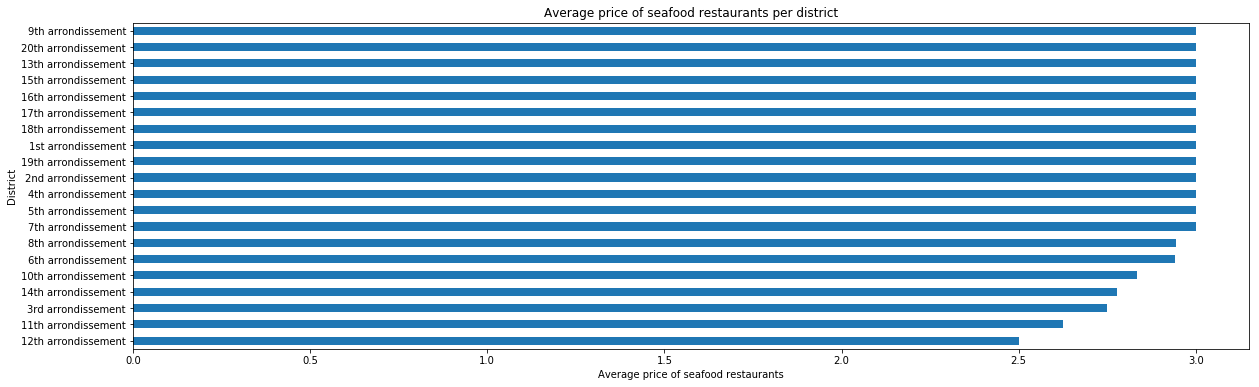

In [86]:
bar_chart_district_price_df.plot(kind='barh', figsize=(20, 6))

plt.xlabel('Average price of ' + RESTAURANT_CATEGORY + ' restaurants')
plt.ylabel('District')
plt.title('Average price of ' + RESTAURANT_CATEGORY + ' restaurants per district')
plt.legend().remove()

plt.show()

## 5. Create clusters

### DBSCAN algorithm

#### Import libraries

In [87]:
from sklearn.cluster import DBSCAN
print('DBSCAN library imported.')
import sklearn.utils
print('sklearn.utils library imported.')
from sklearn.preprocessing import StandardScaler
print('StandardScaler library imported.')
import matplotlib.cm as cm
print('matplotlib.cm library imported.')
import matplotlib.colors as colors
print('matplotlib.colors library imported.')

print('All libraries imported.')

DBSCAN library imported.
sklearn.utils library imported.
StandardScaler library imported.
matplotlib.cm library imported.
matplotlib.colors library imported.
All libraries imported.


#### Run the algorithm

Constants of the DBSCAN algorithm:

In [88]:
EPSILON = 0.3 #Epsilon determine a specified radius that if includes enough number of points within, we call it dense area  
MINIMUM_SAMPLES = 5 #Minimum samples determine the minimum number of data points we want in a neighborhood to define a cluster.

Create the data set that will be used for the DBSCAN algorithm.

In [89]:
sklearn.utils.check_random_state(1000)

restaurants_paris_details_dbscan = restaurants_paris_details.copy()

cluster_data_set = restaurants_paris_details_dbscan[['Latitude', 'Longitude', 'Price', 'Rating']] #Columns kept = parameters used to create the clusters
cluster_data_set = cluster_data_set.fillna(cluster_data_set.mean()) #Replace empty cells (NaN) by the mean of the column
cluster_data_set = StandardScaler().fit_transform(cluster_data_set)

Run the DBSCAN algorithm.

In [90]:
dbscan = DBSCAN(eps=EPSILON, min_samples=MINIMUM_SAMPLES).fit(cluster_data_set)
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

#### Clean the output

Add the cluster number to each restaurant.

In [91]:
labels = dbscan.labels_
restaurants_paris_details_dbscan['ClusterDBSCAN'] = labels

print('The dataframe shape is {}.'.format(restaurants_paris_details_dbscan.shape))
print('The dataframe types are:\n{}.'.format(restaurants_paris_details_dbscan.dtypes))
restaurants_paris_details_dbscan.head()

The dataframe shape is (180, 12).
The dataframe types are:
id                    object
Name                  object
Latitude             float64
Longitude            float64
Price                float64
PriceDescription      object
Rating               float64
Likes                  int64
TipsCount              int64
IsPrimaryCategory       bool
NeighborhoodCode       int64
ClusterDBSCAN          int64
dtype: object.


id                   Name   Latitude  Longitude  \
0  4ea456aa61af76b39d5803a1      La Belle de Liron  48.866846   2.347244   
1  4b5ff171f964a5204cd129e3          Nautilus Food  48.872344   2.342870   
2  4bd2011c046076b0bb017371      Léon de Bruxelles  48.883684   2.327870   
3  4b8137c8f964a520e09a30e3               La Criée  48.870531   2.348942   
4  56b8e71c498e33f2f695cd55  Restaurant Le Sichuan  48.870730   2.355052   

   Price PriceDescription  Rating  Likes  TipsCount  IsPrimaryCategory  \
0    3.0        Expensive     NaN      0          0               True   
1    3.0        Expensive     NaN      0          0               True   
2    3.0        Expensive     6.9     46         19               True   
3    3.0        Expensive     7.9     28          9               True   
4    3.0        Expensive     NaN      0          0               True   

   NeighborhoodCode  ClusterDBSCAN  
0           7510203              3  
1           7510903             -1  
2           7511801             -1  
3           7511002             -1  
4           7511003             -1

#### Visualize the result

Obtain the GeoJSON from IBM Cloud.

In [92]:
paris_neighborhoods_geo_file = project.get_file('paris_neighborhoods_geo.json')
paris_neighborhoods_geo = pd.read_json(paris_neighborhoods_geo_file)
print('File paris_neighborhoods_geo.json loaded.')

paris_neighborhoods_geo = r'paris_neighborhoods_geo.json'

File paris_neighborhoods_geo.json loaded.


Add the clusters to a map.

In [93]:
DBSCAN_map = folium.Map(location=PARIS_COORDINATES, zoom_start=13, tiles='OpenStreetMap')

folium.GeoJson(
    data=paris_neighborhoods_geo,
    style_function=lambda x: {'color': 'grey', 'opacity': 0.5, 'weight': 2, 'fillColor': 'grey', 'fill_opacity': 0.05},
    tooltip=folium.GeoJsonTooltip(fields=(['l_qu']),labels=False)
).add_to(DBSCAN_map)

#Set color scheme for the clusters
real_cluster_count =len(set(labels))
x = np.arange(real_cluster_count)
ys = [i + x + (i*x)**2 for i in range(real_cluster_count)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers to the map
markers_colors = []
for latitude, longitude, name, cluster in zip(restaurants_paris_details_dbscan['Latitude'], restaurants_paris_details_dbscan['Longitude'], restaurants_paris_details_dbscan['Name'], restaurants_paris_details_dbscan['ClusterDBSCAN']):
    label = folium.Popup(name + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='#555555' if cluster == -1 else rainbow[cluster-1],
        fill=True,
        fill_color='#555555' if cluster == -1 else rainbow[cluster-1],
        fill_opacity=0.7).add_to(DBSCAN_map)
       
DBSCAN_map

### k-Means algorithm

#### Import libraries

In [94]:
from sklearn.cluster import KMeans
print('KMeans library imported.')

print('All libraries imported.')

KMeans library imported.
All libraries imported.


#### Run the algorithm

Constants of the k-Means algorithm:

In [95]:
KCLUSTERS = 5 #Number of clusters for k-Means method

Create the data set that will be used for the k-Means algorithm.

In [96]:
restaurants_paris_details_kmeans = restaurants_paris_details.copy()
restaurants_paris_details_kmeans = restaurants_paris_details_kmeans[['Latitude', 'Longitude', 'Price', 'Rating']] #Only keep the needed columns, i.e. the ones that will be used as parameters to create the clusters
restaurants_paris_details_kmeans = restaurants_paris_details_kmeans.fillna(restaurants_paris_details_kmeans.mean()) #Replace empty cells (NaN) by the mean of the column

print('The dataframe shape is {}.'.format(restaurants_paris_details_kmeans.shape))
print('The dataframe types are:\n{}.'.format(restaurants_paris_details_kmeans.dtypes))
restaurants_paris_details_kmeans.head()

The dataframe shape is (180, 4).
The dataframe types are:
Latitude     float64
Longitude    float64
Price        float64
Rating       float64
dtype: object.


Latitude  Longitude  Price    Rating
0  48.866846   2.347244    3.0  7.597753
1  48.872344   2.342870    3.0  7.597753
2  48.883684   2.327870    3.0  6.900000
3  48.870531   2.348942    3.0  7.900000
4  48.870730   2.355052    3.0  7.597753

Run the k-Means algorithm.

In [97]:
kmeans = KMeans(n_clusters=KCLUSTERS, random_state=0).fit(restaurants_paris_details_kmeans)

#### Clean the output

Add the cluster number to each restaurant.

In [98]:
restaurants_paris_details_kmeans_final = restaurants_paris_details.copy()
restaurants_paris_details_kmeans_final.insert(0, 'ClusterKMeans', kmeans.labels_)
restaurants_paris_details_kmeans_final.dropna(subset=['ClusterKMeans'], inplace=True)

print('The dataframe shape is {}.'.format(restaurants_paris_details_kmeans_final.shape))
print('The dataframe types are:\n{}.'.format(restaurants_paris_details_kmeans_final.dtypes))
restaurants_paris_details_kmeans_final.head()

The dataframe shape is (180, 12).
The dataframe types are:
ClusterKMeans          int32
id                    object
Name                  object
Latitude             float64
Longitude            float64
Price                float64
PriceDescription      object
Rating               float64
Likes                  int64
TipsCount              int64
IsPrimaryCategory       bool
NeighborhoodCode       int64
dtype: object.


ClusterKMeans                        id                   Name   Latitude  \
0              0  4ea456aa61af76b39d5803a1      La Belle de Liron  48.866846   
1              0  4b5ff171f964a5204cd129e3          Nautilus Food  48.872344   
2              3  4bd2011c046076b0bb017371      Léon de Bruxelles  48.883684   
3              0  4b8137c8f964a520e09a30e3               La Criée  48.870531   
4              0  56b8e71c498e33f2f695cd55  Restaurant Le Sichuan  48.870730   

   Longitude  Price PriceDescription  Rating  Likes  TipsCount  \
0   2.347244    3.0        Expensive     NaN      0          0   
1   2.342870    3.0        Expensive     NaN      0          0   
2   2.327870    3.0        Expensive     6.9     46         19   
3   2.348942    3.0        Expensive     7.9     28          9   
4   2.355052    3.0        Expensive     NaN      0          0   

   IsPrimaryCategory  NeighborhoodCode  
0               True           7510203  
1               True           7510903  
2               True           7511801  
3               True           7511002  
4               True           7511003

#### Visualize the result

Obtain the GeoJSON from IBM Cloud.

In [99]:
paris_neighborhoods_geo_file = project.get_file('paris_neighborhoods_geo.json')
paris_neighborhoods_geo = pd.read_json(paris_neighborhoods_geo_file)
print('File paris_neighborhoods_geo.json loaded.')

paris_neighborhoods_geo = r'paris_neighborhoods_geo.json'

File paris_neighborhoods_geo.json loaded.


Add the clusters to a map.

In [100]:
KMeans_map = folium.Map(location=PARIS_COORDINATES, zoom_start=13, tiles='OpenStreetMap')

folium.GeoJson(
    data=paris_neighborhoods_geo,
    style_function=lambda x: {'color': 'grey', 'opacity': 0.5, 'weight': 2, 'fillColor': 'grey', 'fill_opacity': 0.05},
    tooltip=folium.GeoJsonTooltip(fields=(['l_qu']),labels=False)
).add_to(KMeans_map)

# set color scheme for the clusters
x = np.arange(KCLUSTERS)
ys = [i + x + (i*x)**2 for i in range(KCLUSTERS)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for latitude, longitude, name, cluster in zip(restaurants_paris_details_kmeans_final['Latitude'], restaurants_paris_details_kmeans_final['Longitude'], restaurants_paris_details_kmeans_final['Name'], restaurants_paris_details_kmeans_final['ClusterKMeans']):
    cluster = int(cluster)
    label = folium.Popup(name + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(KMeans_map)
       
KMeans_map

## Conclusion

See the report and the presentation.